In [1]:
# Mixed new and old data

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
#from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import load_model
# Set the random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



def build_unet(input_shape, seed_value=42):
    
    # Create input layers
    input_low_geometry = Input(shape=input_shape, name='low_geometry_input')
   
    

    

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(input_low_geometry )
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv5)

    # Expanding path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv9)

    # Velocity output layer
    velocity_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='velocity_output')(conv9)

    # Pressure output layer
    pressure_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='pressure_output')(conv9)

    model = Model(inputs=input_low_geometry, outputs=[pressure_outputs, velocity_outputs])
    return model




def data_loss(y_true, y_pred):
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)
    # Data loss function for velocity and pressure
    d_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return d_loss



# Train the model with your dataset
import os
import numpy as np
from PIL import Image
from keras.callbacks import ModelCheckpoint

# Set the paths to the data folders



hv_folder = 'High/HVV'
hp_folder = 'High/HPP'
lg_folder = 'LG-3C2'



# Get the list of file names in each folder

hv_files = [f for f in os.listdir(hv_folder) if f != ".ipynb_checkpoints"]
hp_files = [f for f in os.listdir(hp_folder) if f != ".ipynb_checkpoints"]
lg_files = [f for f in os.listdir(lg_folder) if f != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent

hv_files.sort()
hp_files.sort()
lg_files.sort()


# Set the input shape
input_shape = (256, 256, 3)  # Update to 3 channels for color images

# Create empty lists to store the data

X_lg = []
Y_hv = []
Y_hp = []

# Read the data from the folders
for hv_file,hp_file,lg_file in zip( hv_files,hp_files,lg_files):
    try:
        
        
        # Read the HFV
        hv_image = np.load(os.path.join(hv_folder, hv_file))  # Convert to RGB
        Y_hv.append(np.array(hv_image))

    
    
        # Read the channel geometry image
        lg_image = Image.open(os.path.join(lg_folder, lg_file)).convert('RGB')  # Convert to RGB
        lg_image = lg_image.resize(input_shape[:2])  # Resize the image
        X_lg.append(np.array(lg_image))
    
        # Read the HFP
        hp_image = np.load(os.path.join(hp_folder, hp_file))  # Convert to RGB
        Y_hp.append(np.array(hp_image))
    except:
        print('')

# Convert the lists to arrays
X_lg = np.array(X_lg) / 255.0  # Normalize the channel geometry images
Y_hv = np.array(Y_hv)
Y_hp = np.array(Y_hp)

Y_hpt=(Y_hp-np.min(Y_hp))/(np.max(Y_hp)-np.min(Y_hp))






# Build the U-Net model
model = build_unet(input_shape)


optim = Adam(learning_rate=0.00001)
# Compile the model with the desired loss functions
model.compile(optimizer=optim,
              loss=[data_loss,data_loss])
# Set up checkpoints to save the best model during training
checkpoint_path = 'Saved_Models_Temp/Final-Data-Unet-Zero.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Train the model
epochs = 2400
batch_size = 16
print('start fitting')
model.fit(X_lg, [Y_hpt, Y_hv],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[checkpoint])





2025-03-27 23:31:09.120534: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-03-27 23:31:09.120555: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2025-03-27 23:31:09.120559: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2025-03-27 23:31:09.120594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-27 23:31:09.120607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


start fitting
Epoch 1/2400


2025-03-27 23:31:11.363704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - ETA: 0s - loss: 0.1657 - pressure_output_loss: 0.0615 - velocity_output_loss: 0.1042

2025-03-27 23:32:23.518409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.01717, saving model to Saved_Models/Final-Data-Unet-Zero.h5


/Users/trina-mrd-lab2/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - 78s 547ms/step - loss: 0.1657 - pressure_output_loss: 0.0615 - velocity_output_loss: 0.1042 - val_loss: 0.0172 - val_pressure_output_loss: 0.0163 - val_velocity_output_loss: 8.9633e-04
Epoch 2/2400
142/142 [==============================] - ETA: 0s - loss: 0.0231 - pressure_output_loss: 0.0205 - velocity_output_loss: 0.0026
Epoch 2: val_loss improved from 0.01717 to 0.01661, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 77s 543ms/step - loss: 0.0231 - pressure_output_loss: 0.0205 - velocity_output_loss: 0.0026 - val_loss: 0.0166 - val_pressure_output_loss: 0.0155 - val_velocity_output_loss: 0.0011
Epoch 3/2400
142/142 [==============================] - ETA: 0s - loss: 0.0131 - pressure_output_loss: 0.0077 - velocity_output_loss: 0.0055
Epoch 3: val_loss improved from 0.01661 to 0.00773, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 77s 542ms/ste

Epoch 19/2400
142/142 [==============================] - ETA: 0s - loss: 0.0014 - pressure_output_loss: 3.9081e-04 - velocity_output_loss: 0.0010
Epoch 19: val_loss did not improve from 0.00062
142/142 [==============================] - 84s 591ms/step - loss: 0.0014 - pressure_output_loss: 3.9081e-04 - velocity_output_loss: 0.0010 - val_loss: 6.3312e-04 - val_pressure_output_loss: 3.0162e-04 - val_velocity_output_loss: 3.3150e-04
Epoch 20/2400
142/142 [==============================] - ETA: 0s - loss: 0.0014 - pressure_output_loss: 3.8004e-04 - velocity_output_loss: 9.7351e-04
Epoch 20: val_loss improved from 0.00062 to 0.00058, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 84s 592ms/step - loss: 0.0014 - pressure_output_loss: 3.8004e-04 - velocity_output_loss: 9.7351e-04 - val_loss: 5.8169e-04 - val_pressure_output_loss: 3.2310e-04 - val_velocity_output_loss: 2.5859e-04
Epoch 21/2400
142/142 [==============================] - ETA: 0s -

142/142 [==============================] - 83s 588ms/step - loss: 0.0011 - pressure_output_loss: 3.0936e-04 - velocity_output_loss: 7.9140e-04 - val_loss: 4.1786e-04 - val_pressure_output_loss: 2.4579e-04 - val_velocity_output_loss: 1.7208e-04
Epoch 37/2400
142/142 [==============================] - ETA: 0s - loss: 0.0011 - pressure_output_loss: 3.0470e-04 - velocity_output_loss: 7.8597e-04
Epoch 37: val_loss did not improve from 0.00042
142/142 [==============================] - 83s 582ms/step - loss: 0.0011 - pressure_output_loss: 3.0470e-04 - velocity_output_loss: 7.8597e-04 - val_loss: 4.5519e-04 - val_pressure_output_loss: 3.0098e-04 - val_velocity_output_loss: 1.5420e-04
Epoch 38/2400
142/142 [==============================] - ETA: 0s - loss: 0.0011 - pressure_output_loss: 3.0032e-04 - velocity_output_loss: 7.7940e-04
Epoch 38: val_loss improved from 0.00042 to 0.00040, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 83s 585ms/step 

Epoch 54/2400
142/142 [==============================] - ETA: 0s - loss: 8.8543e-04 - pressure_output_loss: 2.0660e-04 - velocity_output_loss: 6.7882e-04
Epoch 54: val_loss did not improve from 0.00024
142/142 [==============================] - 84s 594ms/step - loss: 8.8543e-04 - pressure_output_loss: 2.0660e-04 - velocity_output_loss: 6.7882e-04 - val_loss: 2.9379e-04 - val_pressure_output_loss: 1.4499e-04 - val_velocity_output_loss: 1.4880e-04
Epoch 55/2400
142/142 [==============================] - ETA: 0s - loss: 8.6129e-04 - pressure_output_loss: 1.9601e-04 - velocity_output_loss: 6.6528e-04
Epoch 55: val_loss did not improve from 0.00024
142/142 [==============================] - 84s 595ms/step - loss: 8.6129e-04 - pressure_output_loss: 1.9601e-04 - velocity_output_loss: 6.6528e-04 - val_loss: 2.5535e-04 - val_pressure_output_loss: 1.2331e-04 - val_velocity_output_loss: 1.3204e-04
Epoch 56/2400
142/142 [==============================] - ETA: 0s - loss: 8.5501e-04 - pressure_outpu

Epoch 89/2400
142/142 [==============================] - ETA: 0s - loss: 6.8949e-04 - pressure_output_loss: 1.4190e-04 - velocity_output_loss: 5.4759e-04
Epoch 89: val_loss did not improve from 0.00016
142/142 [==============================] - 84s 592ms/step - loss: 6.8949e-04 - pressure_output_loss: 1.4190e-04 - velocity_output_loss: 5.4759e-04 - val_loss: 1.6737e-04 - val_pressure_output_loss: 6.2152e-05 - val_velocity_output_loss: 1.0521e-04
Epoch 90/2400
142/142 [==============================] - ETA: 0s - loss: 6.8895e-04 - pressure_output_loss: 1.4287e-04 - velocity_output_loss: 5.4608e-04
Epoch 90: val_loss improved from 0.00016 to 0.00016, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 84s 592ms/step - loss: 6.8895e-04 - pressure_output_loss: 1.4287e-04 - velocity_output_loss: 5.4608e-04 - val_loss: 1.5797e-04 - val_pressure_output_loss: 5.3096e-05 - val_velocity_output_loss: 1.0488e-04
Epoch 91/2400
142/142 [===================

142/142 [==============================] - 84s 592ms/step - loss: 6.1931e-04 - pressure_output_loss: 1.3156e-04 - velocity_output_loss: 4.8775e-04 - val_loss: 1.3160e-04 - val_pressure_output_loss: 4.0690e-05 - val_velocity_output_loss: 9.0914e-05
Epoch 124/2400
142/142 [==============================] - ETA: 0s - loss: 6.0848e-04 - pressure_output_loss: 1.2678e-04 - velocity_output_loss: 4.8171e-04
Epoch 124: val_loss improved from 0.00013 to 0.00013, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 84s 592ms/step - loss: 6.0848e-04 - pressure_output_loss: 1.2678e-04 - velocity_output_loss: 4.8171e-04 - val_loss: 1.3107e-04 - val_pressure_output_loss: 3.9913e-05 - val_velocity_output_loss: 9.1162e-05
Epoch 125/2400
142/142 [==============================] - ETA: 0s - loss: 6.1177e-04 - pressure_output_loss: 1.3151e-04 - velocity_output_loss: 4.8026e-04
Epoch 125: val_loss did not improve from 0.00013
142/142 [=============================

Epoch 141/2400
142/142 [==============================] - ETA: 0s - loss: 5.1647e-04 - pressure_output_loss: 1.2656e-04 - velocity_output_loss: 3.8991e-04
Epoch 141: val_loss improved from 0.00012 to 0.00012, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 85s 601ms/step - loss: 5.1647e-04 - pressure_output_loss: 1.2656e-04 - velocity_output_loss: 3.8991e-04 - val_loss: 1.1810e-04 - val_pressure_output_loss: 4.2686e-05 - val_velocity_output_loss: 7.5416e-05
Epoch 142/2400
142/142 [==============================] - ETA: 0s - loss: 5.1309e-04 - pressure_output_loss: 1.2328e-04 - velocity_output_loss: 3.8981e-04
Epoch 142: val_loss did not improve from 0.00012
142/142 [==============================] - 84s 594ms/step - loss: 5.1309e-04 - pressure_output_loss: 1.2328e-04 - velocity_output_loss: 3.8981e-04 - val_loss: 1.2644e-04 - val_pressure_output_loss: 5.0619e-05 - val_velocity_output_loss: 7.5818e-05
Epoch 143/2400
142/142 [==============

Epoch 159/2400
142/142 [==============================] - ETA: 0s - loss: 4.6843e-04 - pressure_output_loss: 1.1689e-04 - velocity_output_loss: 3.5154e-04
Epoch 159: val_loss did not improve from 0.00011
142/142 [==============================] - 83s 585ms/step - loss: 4.6843e-04 - pressure_output_loss: 1.1689e-04 - velocity_output_loss: 3.5154e-04 - val_loss: 1.6431e-04 - val_pressure_output_loss: 8.5361e-05 - val_velocity_output_loss: 7.8953e-05
Epoch 160/2400
142/142 [==============================] - ETA: 0s - loss: 4.6140e-04 - pressure_output_loss: 1.1642e-04 - velocity_output_loss: 3.4498e-04
Epoch 160: val_loss did not improve from 0.00011
142/142 [==============================] - 83s 586ms/step - loss: 4.6140e-04 - pressure_output_loss: 1.1642e-04 - velocity_output_loss: 3.4498e-04 - val_loss: 1.0710e-04 - val_pressure_output_loss: 3.9109e-05 - val_velocity_output_loss: 6.7988e-05
Epoch 161/2400
142/142 [==============================] - ETA: 0s - loss: 4.5376e-04 - pressure_

Epoch 177/2400
142/142 [==============================] - ETA: 0s - loss: 4.1681e-04 - pressure_output_loss: 1.0458e-04 - velocity_output_loss: 3.1223e-04
Epoch 177: val_loss did not improve from 0.00009
142/142 [==============================] - 84s 591ms/step - loss: 4.1681e-04 - pressure_output_loss: 1.0458e-04 - velocity_output_loss: 3.1223e-04 - val_loss: 1.1196e-04 - val_pressure_output_loss: 4.6161e-05 - val_velocity_output_loss: 6.5803e-05
Epoch 178/2400
142/142 [==============================] - ETA: 0s - loss: 4.1470e-04 - pressure_output_loss: 1.0429e-04 - velocity_output_loss: 3.1042e-04
Epoch 178: val_loss did not improve from 0.00009
142/142 [==============================] - 84s 593ms/step - loss: 4.1470e-04 - pressure_output_loss: 1.0429e-04 - velocity_output_loss: 3.1042e-04 - val_loss: 1.1041e-04 - val_pressure_output_loss: 3.9894e-05 - val_velocity_output_loss: 7.0513e-05
Epoch 179/2400
142/142 [==============================] - ETA: 0s - loss: 4.1362e-04 - pressure_

Epoch 195/2400
142/142 [==============================] - ETA: 0s - loss: 3.7927e-04 - pressure_output_loss: 9.4685e-05 - velocity_output_loss: 2.8458e-04
Epoch 195: val_loss did not improve from 0.00009
142/142 [==============================] - 88s 617ms/step - loss: 3.7927e-04 - pressure_output_loss: 9.4685e-05 - velocity_output_loss: 2.8458e-04 - val_loss: 9.5212e-05 - val_pressure_output_loss: 3.1713e-05 - val_velocity_output_loss: 6.3499e-05
Epoch 196/2400
142/142 [==============================] - ETA: 0s - loss: 3.8123e-04 - pressure_output_loss: 9.3715e-05 - velocity_output_loss: 2.8752e-04
Epoch 196: val_loss did not improve from 0.00009
142/142 [==============================] - 89s 624ms/step - loss: 3.8123e-04 - pressure_output_loss: 9.3715e-05 - velocity_output_loss: 2.8752e-04 - val_loss: 8.8340e-05 - val_pressure_output_loss: 2.9369e-05 - val_velocity_output_loss: 5.8971e-05
Epoch 197/2400
142/142 [==============================] - ETA: 0s - loss: 3.6882e-04 - pressure_

Epoch 213/2400
142/142 [==============================] - ETA: 0s - loss: 3.5886e-04 - pressure_output_loss: 9.2423e-05 - velocity_output_loss: 2.6643e-04
Epoch 213: val_loss did not improve from 0.00008
142/142 [==============================] - 84s 590ms/step - loss: 3.5886e-04 - pressure_output_loss: 9.2423e-05 - velocity_output_loss: 2.6643e-04 - val_loss: 1.7168e-04 - val_pressure_output_loss: 6.7378e-05 - val_velocity_output_loss: 1.0430e-04
Epoch 214/2400
142/142 [==============================] - ETA: 0s - loss: 4.0176e-04 - pressure_output_loss: 1.1285e-04 - velocity_output_loss: 2.8891e-04
Epoch 214: val_loss did not improve from 0.00008
142/142 [==============================] - 84s 595ms/step - loss: 4.0176e-04 - pressure_output_loss: 1.1285e-04 - velocity_output_loss: 2.8891e-04 - val_loss: 8.5938e-05 - val_pressure_output_loss: 3.1857e-05 - val_velocity_output_loss: 5.4082e-05
Epoch 215/2400
142/142 [==============================] - ETA: 0s - loss: 3.7408e-04 - pressure_

Epoch 231/2400
142/142 [==============================] - ETA: 0s - loss: 3.2261e-04 - pressure_output_loss: 7.9289e-05 - velocity_output_loss: 2.4332e-04
Epoch 231: val_loss did not improve from 0.00008
142/142 [==============================] - 83s 587ms/step - loss: 3.2261e-04 - pressure_output_loss: 7.9289e-05 - velocity_output_loss: 2.4332e-04 - val_loss: 7.9094e-05 - val_pressure_output_loss: 2.9897e-05 - val_velocity_output_loss: 4.9196e-05
Epoch 232/2400
142/142 [==============================] - ETA: 0s - loss: 3.2660e-04 - pressure_output_loss: 8.2095e-05 - velocity_output_loss: 2.4451e-04
Epoch 232: val_loss improved from 0.00008 to 0.00008, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 84s 594ms/step - loss: 3.2660e-04 - pressure_output_loss: 8.2095e-05 - velocity_output_loss: 2.4451e-04 - val_loss: 7.5369e-05 - val_pressure_output_loss: 2.6946e-05 - val_velocity_output_loss: 4.8423e-05
Epoch 233/2400
142/142 [==============

Epoch 249/2400
142/142 [==============================] - ETA: 0s - loss: 2.9704e-04 - pressure_output_loss: 7.3570e-05 - velocity_output_loss: 2.2347e-04
Epoch 249: val_loss did not improve from 0.00007
142/142 [==============================] - 85s 599ms/step - loss: 2.9704e-04 - pressure_output_loss: 7.3570e-05 - velocity_output_loss: 2.2347e-04 - val_loss: 9.0509e-05 - val_pressure_output_loss: 4.5267e-05 - val_velocity_output_loss: 4.5242e-05
Epoch 250/2400
142/142 [==============================] - ETA: 0s - loss: 2.9687e-04 - pressure_output_loss: 7.2787e-05 - velocity_output_loss: 2.2408e-04
Epoch 250: val_loss did not improve from 0.00007
142/142 [==============================] - 84s 591ms/step - loss: 2.9687e-04 - pressure_output_loss: 7.2787e-05 - velocity_output_loss: 2.2408e-04 - val_loss: 7.7155e-05 - val_pressure_output_loss: 2.6056e-05 - val_velocity_output_loss: 5.1100e-05
Epoch 251/2400
142/142 [==============================] - ETA: 0s - loss: 2.9542e-04 - pressure_

Epoch 267/2400
142/142 [==============================] - ETA: 0s - loss: 2.7890e-04 - pressure_output_loss: 6.9674e-05 - velocity_output_loss: 2.0923e-04
Epoch 267: val_loss did not improve from 0.00007
142/142 [==============================] - 84s 594ms/step - loss: 2.7890e-04 - pressure_output_loss: 6.9674e-05 - velocity_output_loss: 2.0923e-04 - val_loss: 7.1513e-05 - val_pressure_output_loss: 2.9520e-05 - val_velocity_output_loss: 4.1993e-05
Epoch 268/2400
142/142 [==============================] - ETA: 0s - loss: 2.8149e-04 - pressure_output_loss: 7.2145e-05 - velocity_output_loss: 2.0935e-04
Epoch 268: val_loss did not improve from 0.00007
142/142 [==============================] - 86s 604ms/step - loss: 2.8149e-04 - pressure_output_loss: 7.2145e-05 - velocity_output_loss: 2.0935e-04 - val_loss: 7.8435e-05 - val_pressure_output_loss: 3.3950e-05 - val_velocity_output_loss: 4.4486e-05
Epoch 269/2400
142/142 [==============================] - ETA: 0s - loss: 2.8514e-04 - pressure_

Epoch 285/2400
142/142 [==============================] - ETA: 0s - loss: 2.6050e-04 - pressure_output_loss: 6.6773e-05 - velocity_output_loss: 1.9373e-04
Epoch 285: val_loss did not improve from 0.00006
142/142 [==============================] - 84s 592ms/step - loss: 2.6050e-04 - pressure_output_loss: 6.6773e-05 - velocity_output_loss: 1.9373e-04 - val_loss: 6.4447e-05 - val_pressure_output_loss: 2.3274e-05 - val_velocity_output_loss: 4.1174e-05
Epoch 286/2400
142/142 [==============================] - ETA: 0s - loss: 2.5883e-04 - pressure_output_loss: 6.6958e-05 - velocity_output_loss: 1.9187e-04
Epoch 286: val_loss did not improve from 0.00006
142/142 [==============================] - 84s 593ms/step - loss: 2.5883e-04 - pressure_output_loss: 6.6958e-05 - velocity_output_loss: 1.9187e-04 - val_loss: 6.7047e-05 - val_pressure_output_loss: 2.3523e-05 - val_velocity_output_loss: 4.3524e-05
Epoch 287/2400
142/142 [==============================] - ETA: 0s - loss: 2.6183e-04 - pressure_

Epoch 303/2400
142/142 [==============================] - ETA: 0s - loss: 2.5944e-04 - pressure_output_loss: 7.0825e-05 - velocity_output_loss: 1.8862e-04
Epoch 303: val_loss did not improve from 0.00006
142/142 [==============================] - 88s 618ms/step - loss: 2.5944e-04 - pressure_output_loss: 7.0825e-05 - velocity_output_loss: 1.8862e-04 - val_loss: 6.4967e-05 - val_pressure_output_loss: 2.5100e-05 - val_velocity_output_loss: 3.9866e-05
Epoch 304/2400
142/142 [==============================] - ETA: 0s - loss: 2.6134e-04 - pressure_output_loss: 7.6395e-05 - velocity_output_loss: 1.8495e-04
Epoch 304: val_loss did not improve from 0.00006
142/142 [==============================] - 87s 610ms/step - loss: 2.6134e-04 - pressure_output_loss: 7.6395e-05 - velocity_output_loss: 1.8495e-04 - val_loss: 6.4806e-05 - val_pressure_output_loss: 2.3912e-05 - val_velocity_output_loss: 4.0894e-05
Epoch 305/2400
142/142 [==============================] - ETA: 0s - loss: 2.4402e-04 - pressure_

Epoch 321/2400
142/142 [==============================] - ETA: 0s - loss: 2.3615e-04 - pressure_output_loss: 6.6275e-05 - velocity_output_loss: 1.6988e-04
Epoch 321: val_loss did not improve from 0.00006
142/142 [==============================] - 83s 586ms/step - loss: 2.3615e-04 - pressure_output_loss: 6.6275e-05 - velocity_output_loss: 1.6988e-04 - val_loss: 9.5912e-05 - val_pressure_output_loss: 5.7494e-05 - val_velocity_output_loss: 3.8418e-05
Epoch 322/2400
142/142 [==============================] - ETA: 0s - loss: 2.3484e-04 - pressure_output_loss: 6.4131e-05 - velocity_output_loss: 1.7071e-04
Epoch 322: val_loss did not improve from 0.00006
142/142 [==============================] - 84s 590ms/step - loss: 2.3484e-04 - pressure_output_loss: 6.4131e-05 - velocity_output_loss: 1.7071e-04 - val_loss: 6.2574e-05 - val_pressure_output_loss: 2.4801e-05 - val_velocity_output_loss: 3.7773e-05
Epoch 323/2400
142/142 [==============================] - ETA: 0s - loss: 2.3134e-04 - pressure_

Epoch 339/2400
142/142 [==============================] - ETA: 0s - loss: 2.2347e-04 - pressure_output_loss: 6.1237e-05 - velocity_output_loss: 1.6223e-04
Epoch 339: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 597ms/step - loss: 2.2347e-04 - pressure_output_loss: 6.1237e-05 - velocity_output_loss: 1.6223e-04 - val_loss: 7.0755e-05 - val_pressure_output_loss: 2.9258e-05 - val_velocity_output_loss: 4.1496e-05
Epoch 340/2400
142/142 [==============================] - ETA: 0s - loss: 2.2539e-04 - pressure_output_loss: 6.3123e-05 - velocity_output_loss: 1.6226e-04
Epoch 340: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 596ms/step - loss: 2.2539e-04 - pressure_output_loss: 6.3123e-05 - velocity_output_loss: 1.6226e-04 - val_loss: 6.3757e-05 - val_pressure_output_loss: 2.2141e-05 - val_velocity_output_loss: 4.1616e-05
Epoch 341/2400
142/142 [==============================] - ETA: 0s - loss: 2.2006e-04 - pressure_

Epoch 357/2400
142/142 [==============================] - ETA: 0s - loss: 2.0922e-04 - pressure_output_loss: 5.9637e-05 - velocity_output_loss: 1.4959e-04
Epoch 357: val_loss did not improve from 0.00006
142/142 [==============================] - 83s 587ms/step - loss: 2.0922e-04 - pressure_output_loss: 5.9637e-05 - velocity_output_loss: 1.4959e-04 - val_loss: 6.5144e-05 - val_pressure_output_loss: 2.7950e-05 - val_velocity_output_loss: 3.7193e-05
Epoch 358/2400
142/142 [==============================] - ETA: 0s - loss: 2.1261e-04 - pressure_output_loss: 6.1804e-05 - velocity_output_loss: 1.5081e-04
Epoch 358: val_loss did not improve from 0.00006
142/142 [==============================] - 83s 585ms/step - loss: 2.1261e-04 - pressure_output_loss: 6.1804e-05 - velocity_output_loss: 1.5081e-04 - val_loss: 5.8536e-05 - val_pressure_output_loss: 2.0622e-05 - val_velocity_output_loss: 3.7914e-05
Epoch 359/2400
142/142 [==============================] - ETA: 0s - loss: 2.1182e-04 - pressure_

Epoch 375/2400
142/142 [==============================] - ETA: 0s - loss: 2.0426e-04 - pressure_output_loss: 6.0246e-05 - velocity_output_loss: 1.4402e-04
Epoch 375: val_loss improved from 0.00006 to 0.00006, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 84s 594ms/step - loss: 2.0426e-04 - pressure_output_loss: 6.0246e-05 - velocity_output_loss: 1.4402e-04 - val_loss: 5.5193e-05 - val_pressure_output_loss: 2.0304e-05 - val_velocity_output_loss: 3.4889e-05
Epoch 376/2400
142/142 [==============================] - ETA: 0s - loss: 1.9847e-04 - pressure_output_loss: 5.8000e-05 - velocity_output_loss: 1.4047e-04
Epoch 376: val_loss did not improve from 0.00006
142/142 [==============================] - 84s 592ms/step - loss: 1.9847e-04 - pressure_output_loss: 5.8000e-05 - velocity_output_loss: 1.4047e-04 - val_loss: 7.9883e-05 - val_pressure_output_loss: 4.4052e-05 - val_velocity_output_loss: 3.5831e-05
Epoch 377/2400
142/142 [==============

Epoch 393/2400
142/142 [==============================] - ETA: 0s - loss: 1.9495e-04 - pressure_output_loss: 5.8414e-05 - velocity_output_loss: 1.3653e-04
Epoch 393: val_loss did not improve from 0.00006
142/142 [==============================] - 88s 617ms/step - loss: 1.9495e-04 - pressure_output_loss: 5.8414e-05 - velocity_output_loss: 1.3653e-04 - val_loss: 5.9162e-05 - val_pressure_output_loss: 2.3154e-05 - val_velocity_output_loss: 3.6008e-05
Epoch 394/2400
142/142 [==============================] - ETA: 0s - loss: 1.9285e-04 - pressure_output_loss: 5.7064e-05 - velocity_output_loss: 1.3579e-04
Epoch 394: val_loss improved from 0.00006 to 0.00006, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 89s 629ms/step - loss: 1.9285e-04 - pressure_output_loss: 5.7064e-05 - velocity_output_loss: 1.3579e-04 - val_loss: 5.5193e-05 - val_pressure_output_loss: 2.0262e-05 - val_velocity_output_loss: 3.4931e-05
Epoch 395/2400
142/142 [==============

Epoch 411/2400
142/142 [==============================] - ETA: 0s - loss: 1.8305e-04 - pressure_output_loss: 5.4601e-05 - velocity_output_loss: 1.2845e-04
Epoch 411: val_loss improved from 0.00005 to 0.00005, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 85s 601ms/step - loss: 1.8305e-04 - pressure_output_loss: 5.4601e-05 - velocity_output_loss: 1.2845e-04 - val_loss: 5.2980e-05 - val_pressure_output_loss: 1.9173e-05 - val_velocity_output_loss: 3.3808e-05
Epoch 412/2400
142/142 [==============================] - ETA: 0s - loss: 1.8491e-04 - pressure_output_loss: 5.5215e-05 - velocity_output_loss: 1.2969e-04
Epoch 412: val_loss improved from 0.00005 to 0.00005, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 85s 600ms/step - loss: 1.8491e-04 - pressure_output_loss: 5.5215e-05 - velocity_output_loss: 1.2969e-04 - val_loss: 5.2948e-05 - val_pressure_output_loss: 1.9162e-05 - val_velocity_outp

Epoch 429/2400
142/142 [==============================] - ETA: 0s - loss: 1.7569e-04 - pressure_output_loss: 5.3488e-05 - velocity_output_loss: 1.2220e-04
Epoch 429: val_loss did not improve from 0.00005
142/142 [==============================] - 87s 612ms/step - loss: 1.7569e-04 - pressure_output_loss: 5.3488e-05 - velocity_output_loss: 1.2220e-04 - val_loss: 5.9878e-05 - val_pressure_output_loss: 2.5718e-05 - val_velocity_output_loss: 3.4160e-05
Epoch 430/2400
142/142 [==============================] - ETA: 0s - loss: 1.7966e-04 - pressure_output_loss: 5.5729e-05 - velocity_output_loss: 1.2394e-04
Epoch 430: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 608ms/step - loss: 1.7966e-04 - pressure_output_loss: 5.5729e-05 - velocity_output_loss: 1.2394e-04 - val_loss: 5.9621e-05 - val_pressure_output_loss: 2.5906e-05 - val_velocity_output_loss: 3.3715e-05
Epoch 431/2400
142/142 [==============================] - ETA: 0s - loss: 1.7676e-04 - pressure_

Epoch 447/2400
142/142 [==============================] - ETA: 0s - loss: 1.7115e-04 - pressure_output_loss: 5.3347e-05 - velocity_output_loss: 1.1780e-04
Epoch 447: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 600ms/step - loss: 1.7115e-04 - pressure_output_loss: 5.3347e-05 - velocity_output_loss: 1.1780e-04 - val_loss: 6.2480e-05 - val_pressure_output_loss: 2.9177e-05 - val_velocity_output_loss: 3.3303e-05
Epoch 448/2400
142/142 [==============================] - ETA: 0s - loss: 1.7280e-04 - pressure_output_loss: 5.3731e-05 - velocity_output_loss: 1.1907e-04
Epoch 448: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 598ms/step - loss: 1.7280e-04 - pressure_output_loss: 5.3731e-05 - velocity_output_loss: 1.1907e-04 - val_loss: 5.2702e-05 - val_pressure_output_loss: 1.9922e-05 - val_velocity_output_loss: 3.2780e-05
Epoch 449/2400
142/142 [==============================] - ETA: 0s - loss: 1.6921e-04 - pressure_

142/142 [==============================] - ETA: 0s - loss: 1.5859e-04 - pressure_output_loss: 4.9975e-05 - velocity_output_loss: 1.0862e-04
Epoch 483: val_loss did not improve from 0.00005
142/142 [==============================] - 87s 611ms/step - loss: 1.5859e-04 - pressure_output_loss: 4.9975e-05 - velocity_output_loss: 1.0862e-04 - val_loss: 5.9290e-05 - val_pressure_output_loss: 2.2446e-05 - val_velocity_output_loss: 3.6844e-05
Epoch 484/2400
142/142 [==============================] - ETA: 0s - loss: 1.5482e-04 - pressure_output_loss: 4.6554e-05 - velocity_output_loss: 1.0827e-04
Epoch 484: val_loss did not improve from 0.00005
142/142 [==============================] - 87s 610ms/step - loss: 1.5482e-04 - pressure_output_loss: 4.6554e-05 - velocity_output_loss: 1.0827e-04 - val_loss: 5.8206e-05 - val_pressure_output_loss: 2.6191e-05 - val_velocity_output_loss: 3.2015e-05
Epoch 485/2400
142/142 [==============================] - ETA: 0s - loss: 1.5135e-04 - pressure_output_loss: 4.

Epoch 501/2400
142/142 [==============================] - ETA: 0s - loss: 1.5004e-04 - pressure_output_loss: 4.5872e-05 - velocity_output_loss: 1.0416e-04
Epoch 501: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 603ms/step - loss: 1.5004e-04 - pressure_output_loss: 4.5872e-05 - velocity_output_loss: 1.0416e-04 - val_loss: 5.1967e-05 - val_pressure_output_loss: 1.9585e-05 - val_velocity_output_loss: 3.2382e-05
Epoch 502/2400
142/142 [==============================] - ETA: 0s - loss: 1.5236e-04 - pressure_output_loss: 4.7712e-05 - velocity_output_loss: 1.0465e-04
Epoch 502: val_loss improved from 0.00005 to 0.00005, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 87s 611ms/step - loss: 1.5236e-04 - pressure_output_loss: 4.7712e-05 - velocity_output_loss: 1.0465e-04 - val_loss: 4.9341e-05 - val_pressure_output_loss: 1.7179e-05 - val_velocity_output_loss: 3.2162e-05
Epoch 503/2400
142/142 [==============

Epoch 519/2400
142/142 [==============================] - ETA: 0s - loss: 1.4118e-04 - pressure_output_loss: 4.3107e-05 - velocity_output_loss: 9.8068e-05
Epoch 519: val_loss did not improve from 0.00005
142/142 [==============================] - 84s 592ms/step - loss: 1.4118e-04 - pressure_output_loss: 4.3107e-05 - velocity_output_loss: 9.8068e-05 - val_loss: 5.5387e-05 - val_pressure_output_loss: 2.4510e-05 - val_velocity_output_loss: 3.0878e-05
Epoch 520/2400
142/142 [==============================] - ETA: 0s - loss: 1.5673e-04 - pressure_output_loss: 5.0707e-05 - velocity_output_loss: 1.0602e-04
Epoch 520: val_loss did not improve from 0.00005
142/142 [==============================] - 84s 595ms/step - loss: 1.5673e-04 - pressure_output_loss: 5.0707e-05 - velocity_output_loss: 1.0602e-04 - val_loss: 5.0677e-05 - val_pressure_output_loss: 1.9337e-05 - val_velocity_output_loss: 3.1340e-05
Epoch 521/2400
142/142 [==============================] - ETA: 0s - loss: 1.4027e-04 - pressure_

Epoch 537/2400
142/142 [==============================] - ETA: 0s - loss: 1.3563e-04 - pressure_output_loss: 4.1045e-05 - velocity_output_loss: 9.4588e-05
Epoch 537: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 603ms/step - loss: 1.3563e-04 - pressure_output_loss: 4.1045e-05 - velocity_output_loss: 9.4588e-05 - val_loss: 4.9398e-05 - val_pressure_output_loss: 1.8008e-05 - val_velocity_output_loss: 3.1390e-05
Epoch 538/2400
142/142 [==============================] - ETA: 0s - loss: 1.3921e-04 - pressure_output_loss: 4.2949e-05 - velocity_output_loss: 9.6263e-05
Epoch 538: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 605ms/step - loss: 1.3921e-04 - pressure_output_loss: 4.2949e-05 - velocity_output_loss: 9.6263e-05 - val_loss: 5.2129e-05 - val_pressure_output_loss: 2.0158e-05 - val_velocity_output_loss: 3.1970e-05
Epoch 539/2400
142/142 [==============================] - ETA: 0s - loss: 1.3916e-04 - pressure_

Epoch 573/2400
142/142 [==============================] - ETA: 0s - loss: 1.2829e-04 - pressure_output_loss: 3.9698e-05 - velocity_output_loss: 8.8592e-05
Epoch 573: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 599ms/step - loss: 1.2829e-04 - pressure_output_loss: 3.9698e-05 - velocity_output_loss: 8.8592e-05 - val_loss: 6.3864e-05 - val_pressure_output_loss: 3.1730e-05 - val_velocity_output_loss: 3.2135e-05
Epoch 574/2400
142/142 [==============================] - ETA: 0s - loss: 1.3207e-04 - pressure_output_loss: 4.1837e-05 - velocity_output_loss: 9.0233e-05
Epoch 574: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 601ms/step - loss: 1.3207e-04 - pressure_output_loss: 4.1837e-05 - velocity_output_loss: 9.0233e-05 - val_loss: 5.0116e-05 - val_pressure_output_loss: 2.0318e-05 - val_velocity_output_loss: 2.9797e-05
Epoch 575/2400
142/142 [==============================] - ETA: 0s - loss: 1.2892e-04 - pressure_

Epoch 591/2400
142/142 [==============================] - ETA: 0s - loss: 1.2798e-04 - pressure_output_loss: 4.2452e-05 - velocity_output_loss: 8.5530e-05
Epoch 591: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 606ms/step - loss: 1.2798e-04 - pressure_output_loss: 4.2452e-05 - velocity_output_loss: 8.5530e-05 - val_loss: 5.3964e-05 - val_pressure_output_loss: 1.9509e-05 - val_velocity_output_loss: 3.4455e-05
Epoch 592/2400
142/142 [==============================] - ETA: 0s - loss: 1.4774e-04 - pressure_output_loss: 5.1633e-05 - velocity_output_loss: 9.6108e-05
Epoch 592: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 606ms/step - loss: 1.4774e-04 - pressure_output_loss: 5.1633e-05 - velocity_output_loss: 9.6108e-05 - val_loss: 4.9299e-05 - val_pressure_output_loss: 1.8747e-05 - val_velocity_output_loss: 3.0552e-05
Epoch 593/2400
142/142 [==============================] - ETA: 0s - loss: 1.2472e-04 - pressure_

142/142 [==============================] - ETA: 0s - loss: 1.1742e-04 - pressure_output_loss: 3.7707e-05 - velocity_output_loss: 7.9717e-05
Epoch 627: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 606ms/step - loss: 1.1742e-04 - pressure_output_loss: 3.7707e-05 - velocity_output_loss: 7.9717e-05 - val_loss: 4.7666e-05 - val_pressure_output_loss: 1.8745e-05 - val_velocity_output_loss: 2.8921e-05
Epoch 628/2400
142/142 [==============================] - ETA: 0s - loss: 1.1924e-04 - pressure_output_loss: 3.7115e-05 - velocity_output_loss: 8.2128e-05
Epoch 628: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 1.1924e-04 - pressure_output_loss: 3.7115e-05 - velocity_output_loss: 8.2128e-05 - val_loss: 4.7343e-05 - val_pressure_output_loss: 1.7453e-05 - val_velocity_output_loss: 2.9889e-05
Epoch 629/2400
142/142 [==============================] - ETA: 0s - loss: 1.1732e-04 - pressure_output_loss: 3.

142/142 [==============================] - ETA: 0s - loss: 1.1297e-04 - pressure_output_loss: 3.4984e-05 - velocity_output_loss: 7.7988e-05
Epoch 645: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 1.1297e-04 - pressure_output_loss: 3.4984e-05 - velocity_output_loss: 7.7988e-05 - val_loss: 4.5492e-05 - val_pressure_output_loss: 1.5506e-05 - val_velocity_output_loss: 2.9986e-05
Epoch 646/2400
142/142 [==============================] - ETA: 0s - loss: 1.1358e-04 - pressure_output_loss: 3.6352e-05 - velocity_output_loss: 7.7226e-05
Epoch 646: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 600ms/step - loss: 1.1358e-04 - pressure_output_loss: 3.6352e-05 - velocity_output_loss: 7.7226e-05 - val_loss: 4.5428e-05 - val_pressure_output_loss: 1.5255e-05 - val_velocity_output_loss: 3.0173e-05
Epoch 647/2400
142/142 [==============================] - ETA: 0s - loss: 1.1524e-04 - pressure_output_loss: 3.

142/142 [==============================] - ETA: 0s - loss: 1.1178e-04 - pressure_output_loss: 3.5564e-05 - velocity_output_loss: 7.6213e-05
Epoch 663: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 615ms/step - loss: 1.1178e-04 - pressure_output_loss: 3.5564e-05 - velocity_output_loss: 7.6213e-05 - val_loss: 5.0576e-05 - val_pressure_output_loss: 2.0049e-05 - val_velocity_output_loss: 3.0527e-05
Epoch 664/2400
142/142 [==============================] - ETA: 0s - loss: 1.2318e-04 - pressure_output_loss: 4.1232e-05 - velocity_output_loss: 8.1950e-05
Epoch 664: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 89s 627ms/step - loss: 1.2318e-04 - pressure_output_loss: 4.1232e-05 - velocity_output_loss: 8.1950e-05 - val_loss: 4.3852e-05 - val_pressure_output_loss: 1.5302e-05 - val_velocity_output_loss: 2.8550e-05
Epoch 665/2400
142/142 [=============================

Epoch 681/2400
142/142 [==============================] - ETA: 0s - loss: 1.1152e-04 - pressure_output_loss: 3.6610e-05 - velocity_output_loss: 7.4910e-05
Epoch 681: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 605ms/step - loss: 1.1152e-04 - pressure_output_loss: 3.6610e-05 - velocity_output_loss: 7.4910e-05 - val_loss: 4.8334e-05 - val_pressure_output_loss: 1.9290e-05 - val_velocity_output_loss: 2.9044e-05
Epoch 682/2400
142/142 [==============================] - ETA: 0s - loss: 1.0890e-04 - pressure_output_loss: 3.4951e-05 - velocity_output_loss: 7.3953e-05
Epoch 682: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 606ms/step - loss: 1.0890e-04 - pressure_output_loss: 3.4951e-05 - velocity_output_loss: 7.3953e-05 - val_loss: 4.3733e-05 - val_pressure_output_loss: 1.5573e-05 - val_velocity_output_loss: 2.8160e-05
Epoch 683/2400
142/142 [==============================] - ETA: 0s - loss: 1.0557e-04 - pressure_

Epoch 699/2400
142/142 [==============================] - ETA: 0s - loss: 1.0437e-04 - pressure_output_loss: 3.2843e-05 - velocity_output_loss: 7.1523e-05
Epoch 699: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 604ms/step - loss: 1.0437e-04 - pressure_output_loss: 3.2843e-05 - velocity_output_loss: 7.1523e-05 - val_loss: 4.4510e-05 - val_pressure_output_loss: 1.5745e-05 - val_velocity_output_loss: 2.8765e-05
Epoch 700/2400
142/142 [==============================] - ETA: 0s - loss: 1.0784e-04 - pressure_output_loss: 3.4778e-05 - velocity_output_loss: 7.3066e-05
Epoch 700: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 606ms/step - loss: 1.0784e-04 - pressure_output_loss: 3.4778e-05 - velocity_output_loss: 7.3066e-05 - val_loss: 5.1243e-05 - val_pressure_output_loss: 2.0797e-05 - val_velocity_output_loss: 3.0447e-05
Epoch 701/2400
142/142 [==============================] - ETA: 0s - loss: 1.0414e-04 - pressure_

Epoch 735/2400
142/142 [==============================] - ETA: 0s - loss: 9.8010e-05 - pressure_output_loss: 3.1277e-05 - velocity_output_loss: 6.6733e-05
Epoch 735: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 600ms/step - loss: 9.8010e-05 - pressure_output_loss: 3.1277e-05 - velocity_output_loss: 6.6733e-05 - val_loss: 4.4101e-05 - val_pressure_output_loss: 1.5179e-05 - val_velocity_output_loss: 2.8922e-05
Epoch 736/2400
142/142 [==============================] - ETA: 0s - loss: 9.8851e-05 - pressure_output_loss: 3.2139e-05 - velocity_output_loss: 6.6712e-05
Epoch 736: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 9.8851e-05 - pressure_output_loss: 3.2139e-05 - velocity_output_loss: 6.6712e-05 - val_loss: 4.4037e-05 - val_pressure_output_loss: 1.6322e-05 - val_velocity_output_loss: 2.7715e-05
Epoch 737/2400
142/142 [==============================] - ETA: 0s - loss: 9.9278e-05 - pressure_

Epoch 753/2400
142/142 [==============================] - ETA: 0s - loss: 9.4640e-05 - pressure_output_loss: 3.0020e-05 - velocity_output_loss: 6.4620e-05
Epoch 753: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 9.4640e-05 - pressure_output_loss: 3.0020e-05 - velocity_output_loss: 6.4620e-05 - val_loss: 4.4349e-05 - val_pressure_output_loss: 1.4930e-05 - val_velocity_output_loss: 2.9418e-05
Epoch 754/2400
142/142 [==============================] - ETA: 0s - loss: 9.7463e-05 - pressure_output_loss: 3.0946e-05 - velocity_output_loss: 6.6517e-05
Epoch 754: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 603ms/step - loss: 9.7463e-05 - pressure_output_loss: 3.0946e-05 - velocity_output_loss: 6.6517e-05 - val_loss: 4.3975e-05 - val_pressure_output_loss: 1.6322e-05 - val_velocity_output_loss: 2.7653e-05
Epoch 755/2400
142/142 [==============================] - ETA: 0s - loss: 9.5077e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 9.2035e-05 - pressure_output_loss: 2.9546e-05 - velocity_output_loss: 6.2489e-05
Epoch 789: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 9.2035e-05 - pressure_output_loss: 2.9546e-05 - velocity_output_loss: 6.2489e-05 - val_loss: 4.2938e-05 - val_pressure_output_loss: 1.4610e-05 - val_velocity_output_loss: 2.8328e-05
Epoch 790/2400
142/142 [==============================] - ETA: 0s - loss: 9.2278e-05 - pressure_output_loss: 2.9941e-05 - velocity_output_loss: 6.2336e-05
Epoch 790: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 9.2278e-05 - pressure_output_loss: 2.9941e-05 - velocity_output_loss: 6.2336e-05 - val_loss: 4.2332e-05 - val_pressure_output_loss: 1.4434e-05 - val_velocity_output_loss: 2.7898e-05
Epoch 791/2400
142/142 [==============================] - ETA: 0s - loss: 9.4278e-05 - pressure_output_loss: 3.

Epoch 825/2400
142/142 [==============================] - ETA: 0s - loss: 8.7351e-05 - pressure_output_loss: 2.7800e-05 - velocity_output_loss: 5.9550e-05
Epoch 825: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 604ms/step - loss: 8.7351e-05 - pressure_output_loss: 2.7800e-05 - velocity_output_loss: 5.9550e-05 - val_loss: 4.1360e-05 - val_pressure_output_loss: 1.3865e-05 - val_velocity_output_loss: 2.7495e-05
Epoch 826/2400
142/142 [==============================] - ETA: 0s - loss: 8.5890e-05 - pressure_output_loss: 2.7621e-05 - velocity_output_loss: 5.8269e-05
Epoch 826: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 607ms/step - loss: 8.5890e-05 - pressure_output_loss: 2.7621e-05 - velocity_output_loss: 5.8269e-05 - val_loss: 4.4461e-05 - val_pressure_output_loss: 1.6468e-05 - val_velocity_output_loss: 2.7993e-05
Epoch 827/2400
142/142 [==============================] - ETA: 0s - loss: 8.9228e-05 - pressure_

Epoch 843/2400
142/142 [==============================] - ETA: 0s - loss: 8.7167e-05 - pressure_output_loss: 2.8398e-05 - velocity_output_loss: 5.8769e-05
Epoch 843: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 600ms/step - loss: 8.7167e-05 - pressure_output_loss: 2.8398e-05 - velocity_output_loss: 5.8769e-05 - val_loss: 4.3158e-05 - val_pressure_output_loss: 1.4135e-05 - val_velocity_output_loss: 2.9023e-05
Epoch 844/2400
142/142 [==============================] - ETA: 0s - loss: 8.9002e-05 - pressure_output_loss: 2.9664e-05 - velocity_output_loss: 5.9338e-05
Epoch 844: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 8.9002e-05 - pressure_output_loss: 2.9664e-05 - velocity_output_loss: 5.9338e-05 - val_loss: 4.1436e-05 - val_pressure_output_loss: 1.4403e-05 - val_velocity_output_loss: 2.7033e-05
Epoch 845/2400
142/142 [==============================] - ETA: 0s - loss: 8.7898e-05 - pressure_

Epoch 861/2400
142/142 [==============================] - ETA: 0s - loss: 8.4466e-05 - pressure_output_loss: 2.7648e-05 - velocity_output_loss: 5.6819e-05
Epoch 861: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 610ms/step - loss: 8.4466e-05 - pressure_output_loss: 2.7648e-05 - velocity_output_loss: 5.6819e-05 - val_loss: 4.2220e-05 - val_pressure_output_loss: 1.4731e-05 - val_velocity_output_loss: 2.7490e-05
Epoch 862/2400
142/142 [==============================] - ETA: 0s - loss: 8.3490e-05 - pressure_output_loss: 2.7550e-05 - velocity_output_loss: 5.5940e-05
Epoch 862: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 608ms/step - loss: 8.3490e-05 - pressure_output_loss: 2.7550e-05 - velocity_output_loss: 5.5940e-05 - val_loss: 4.2390e-05 - val_pressure_output_loss: 1.5447e-05 - val_velocity_output_loss: 2.6943e-05
Epoch 863/2400
142/142 [==============================] - ETA: 0s - loss: 8.4314e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 7.9500e-05 - pressure_output_loss: 2.5967e-05 - velocity_output_loss: 5.3533e-05
Epoch 897: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 7.9500e-05 - pressure_output_loss: 2.5967e-05 - velocity_output_loss: 5.3533e-05 - val_loss: 4.3184e-05 - val_pressure_output_loss: 1.5911e-05 - val_velocity_output_loss: 2.7273e-05
Epoch 898/2400
142/142 [==============================] - ETA: 0s - loss: 7.9662e-05 - pressure_output_loss: 2.5852e-05 - velocity_output_loss: 5.3810e-05
Epoch 898: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 595ms/step - loss: 7.9662e-05 - pressure_output_loss: 2.5852e-05 - velocity_output_loss: 5.3810e-05 - val_loss: 4.2278e-05 - val_pressure_output_loss: 1.5241e-05 - val_velocity_output_loss: 2.7036e-05
Epoch 899/2400
142/142 [==============================] - ETA: 0s - loss: 7.9853e-05 - pressure_output_loss: 2.

142/142 [==============================] - ETA: 0s - loss: 8.3930e-05 - pressure_output_loss: 2.8808e-05 - velocity_output_loss: 5.5121e-05
Epoch 933: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 595ms/step - loss: 8.3930e-05 - pressure_output_loss: 2.8808e-05 - velocity_output_loss: 5.5121e-05 - val_loss: 4.4585e-05 - val_pressure_output_loss: 1.5153e-05 - val_velocity_output_loss: 2.9431e-05
Epoch 934/2400
142/142 [==============================] - ETA: 0s - loss: 8.0682e-05 - pressure_output_loss: 2.6896e-05 - velocity_output_loss: 5.3786e-05
Epoch 934: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 8.0682e-05 - pressure_output_loss: 2.6896e-05 - velocity_output_loss: 5.3786e-05 - val_loss: 4.7322e-05 - val_pressure_output_loss: 1.6350e-05 - val_velocity_output_loss: 3.0972e-05
Epoch 935/2400
142/142 [==============================] - ETA: 0s - loss: 8.1237e-05 - pressure_output_loss: 2.

Epoch 969/2400
142/142 [==============================] - ETA: 0s - loss: 7.4970e-05 - pressure_output_loss: 2.4557e-05 - velocity_output_loss: 5.0413e-05
Epoch 969: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 597ms/step - loss: 7.4970e-05 - pressure_output_loss: 2.4557e-05 - velocity_output_loss: 5.0413e-05 - val_loss: 4.0809e-05 - val_pressure_output_loss: 1.4286e-05 - val_velocity_output_loss: 2.6522e-05
Epoch 970/2400
142/142 [==============================] - ETA: 0s - loss: 7.3780e-05 - pressure_output_loss: 2.4130e-05 - velocity_output_loss: 4.9650e-05
Epoch 970: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 7.3780e-05 - pressure_output_loss: 2.4130e-05 - velocity_output_loss: 4.9650e-05 - val_loss: 4.0602e-05 - val_pressure_output_loss: 1.4130e-05 - val_velocity_output_loss: 2.6472e-05
Epoch 971/2400
142/142 [==============================] - ETA: 0s - loss: 7.5917e-05 - pressure_

Epoch 1005/2400
142/142 [==============================] - ETA: 0s - loss: 7.0916e-05 - pressure_output_loss: 2.2809e-05 - velocity_output_loss: 4.8107e-05
Epoch 1005: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 7.0916e-05 - pressure_output_loss: 2.2809e-05 - velocity_output_loss: 4.8107e-05 - val_loss: 4.1555e-05 - val_pressure_output_loss: 1.3024e-05 - val_velocity_output_loss: 2.8531e-05
Epoch 1006/2400
142/142 [==============================] - ETA: 0s - loss: 7.2357e-05 - pressure_output_loss: 2.3218e-05 - velocity_output_loss: 4.9140e-05
Epoch 1006: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 7.2357e-05 - pressure_output_loss: 2.3218e-05 - velocity_output_loss: 4.9140e-05 - val_loss: 3.9402e-05 - val_pressure_output_loss: 1.2727e-05 - val_velocity_output_loss: 2.6676e-05
Epoch 1007/2400
142/142 [==============================] - ETA: 0s - loss: 7.3039e-05 - pres

Epoch 1023/2400
142/142 [==============================] - ETA: 0s - loss: 7.1603e-05 - pressure_output_loss: 2.3556e-05 - velocity_output_loss: 4.8047e-05
Epoch 1023: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 593ms/step - loss: 7.1603e-05 - pressure_output_loss: 2.3556e-05 - velocity_output_loss: 4.8047e-05 - val_loss: 3.9428e-05 - val_pressure_output_loss: 1.2521e-05 - val_velocity_output_loss: 2.6907e-05
Epoch 1024/2400
142/142 [==============================] - ETA: 0s - loss: 7.0719e-05 - pressure_output_loss: 2.2972e-05 - velocity_output_loss: 4.7747e-05
Epoch 1024: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 7.0719e-05 - pressure_output_loss: 2.2972e-05 - velocity_output_loss: 4.7747e-05 - val_loss: 4.3901e-05 - val_pressure_output_loss: 1.4456e-05 - val_velocity_output_loss: 2.9445e-05
Epoch 1025/2400
142/142 [==============================] - ETA: 0s - loss: 6.9254e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 6.8969e-05 - pressure_output_loss: 2.2944e-05 - velocity_output_loss: 4.6026e-05
Epoch 1059: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 602ms/step - loss: 6.8969e-05 - pressure_output_loss: 2.2944e-05 - velocity_output_loss: 4.6026e-05 - val_loss: 4.0530e-05 - val_pressure_output_loss: 1.4409e-05 - val_velocity_output_loss: 2.6120e-05
Epoch 1060/2400
142/142 [==============================] - ETA: 0s - loss: 6.8371e-05 - pressure_output_loss: 2.1824e-05 - velocity_output_loss: 4.6547e-05
Epoch 1060: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 604ms/step - loss: 6.8371e-05 - pressure_output_loss: 2.1824e-05 - velocity_output_loss: 4.6547e-05 - val_loss: 3.9519e-05 - val_pressure_output_loss: 1.2682e-05 - val_velocity_output_loss: 2.6837e-05
Epoch 1061/2400
142/142 [==============================] - ETA: 0s - loss: 6.8498e-05 - pressure_output_loss

Epoch 1077/2400
142/142 [==============================] - ETA: 0s - loss: 6.5755e-05 - pressure_output_loss: 2.1339e-05 - velocity_output_loss: 4.4415e-05
Epoch 1077: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 607ms/step - loss: 6.5755e-05 - pressure_output_loss: 2.1339e-05 - velocity_output_loss: 4.4415e-05 - val_loss: 3.8807e-05 - val_pressure_output_loss: 1.2835e-05 - val_velocity_output_loss: 2.5972e-05
Epoch 1078/2400
142/142 [==============================] - ETA: 0s - loss: 6.4658e-05 - pressure_output_loss: 2.0943e-05 - velocity_output_loss: 4.3716e-05
Epoch 1078: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 607ms/step - loss: 6.4658e-05 - pressure_output_loss: 2.0943e-05 - velocity_output_loss: 4.3716e-05 - val_loss: 3.8942e-05 - val_pressure_output_loss: 1.3037e-05 - val_velocity_output_loss: 2.5905e-05
Epoch 1079/2400
142/142 [==============================] - ETA: 0s - loss: 6.5112e-05 - pres

Epoch 1095/2400
142/142 [==============================] - ETA: 0s - loss: 6.6678e-05 - pressure_output_loss: 2.2180e-05 - velocity_output_loss: 4.4498e-05
Epoch 1095: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 6.6678e-05 - pressure_output_loss: 2.2180e-05 - velocity_output_loss: 4.4498e-05 - val_loss: 3.9442e-05 - val_pressure_output_loss: 1.3255e-05 - val_velocity_output_loss: 2.6187e-05
Epoch 1096/2400
142/142 [==============================] - ETA: 0s - loss: 6.7540e-05 - pressure_output_loss: 2.2576e-05 - velocity_output_loss: 4.4964e-05
Epoch 1096: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 600ms/step - loss: 6.7540e-05 - pressure_output_loss: 2.2576e-05 - velocity_output_loss: 4.4964e-05 - val_loss: 4.1569e-05 - val_pressure_output_loss: 1.4542e-05 - val_velocity_output_loss: 2.7026e-05
Epoch 1097/2400
142/142 [==============================] - ETA: 0s - loss: 6.7217e-05 - pres

Epoch 1131/2400
142/142 [==============================] - ETA: 0s - loss: 6.2397e-05 - pressure_output_loss: 1.9949e-05 - velocity_output_loss: 4.2448e-05
Epoch 1131: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 6.2397e-05 - pressure_output_loss: 1.9949e-05 - velocity_output_loss: 4.2448e-05 - val_loss: 3.8945e-05 - val_pressure_output_loss: 1.3150e-05 - val_velocity_output_loss: 2.5795e-05
Epoch 1132/2400
142/142 [==============================] - ETA: 0s - loss: 6.2527e-05 - pressure_output_loss: 1.9842e-05 - velocity_output_loss: 4.2685e-05
Epoch 1132: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 6.2527e-05 - pressure_output_loss: 1.9842e-05 - velocity_output_loss: 4.2685e-05 - val_loss: 3.9486e-05 - val_pressure_output_loss: 1.3927e-05 - val_velocity_output_loss: 2.5559e-05
Epoch 1133/2400
142/142 [==============================] - ETA: 0s - loss: 6.2471e-05 - pres

Epoch 1167/2400
142/142 [==============================] - ETA: 0s - loss: 6.3036e-05 - pressure_output_loss: 2.0271e-05 - velocity_output_loss: 4.2765e-05
Epoch 1167: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 594ms/step - loss: 6.3036e-05 - pressure_output_loss: 2.0271e-05 - velocity_output_loss: 4.2765e-05 - val_loss: 4.1510e-05 - val_pressure_output_loss: 1.3939e-05 - val_velocity_output_loss: 2.7572e-05
Epoch 1168/2400
142/142 [==============================] - ETA: 0s - loss: 6.1689e-05 - pressure_output_loss: 1.9768e-05 - velocity_output_loss: 4.1921e-05
Epoch 1168: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 594ms/step - loss: 6.1689e-05 - pressure_output_loss: 1.9768e-05 - velocity_output_loss: 4.1921e-05 - val_loss: 3.8652e-05 - val_pressure_output_loss: 1.2328e-05 - val_velocity_output_loss: 2.6324e-05
Epoch 1169/2400
142/142 [==============================] - ETA: 0s - loss: 6.0481e-05 - pres

Epoch 1185/2400
142/142 [==============================] - ETA: 0s - loss: 6.0638e-05 - pressure_output_loss: 1.9682e-05 - velocity_output_loss: 4.0956e-05
Epoch 1185: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 616ms/step - loss: 6.0638e-05 - pressure_output_loss: 1.9682e-05 - velocity_output_loss: 4.0956e-05 - val_loss: 3.9636e-05 - val_pressure_output_loss: 1.2940e-05 - val_velocity_output_loss: 2.6697e-05
Epoch 1186/2400
142/142 [==============================] - ETA: 0s - loss: 6.2262e-05 - pressure_output_loss: 2.0497e-05 - velocity_output_loss: 4.1765e-05
Epoch 1186: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 609ms/step - loss: 6.2262e-05 - pressure_output_loss: 2.0497e-05 - velocity_output_loss: 4.1765e-05 - val_loss: 3.9601e-05 - val_pressure_output_loss: 1.3414e-05 - val_velocity_output_loss: 2.6187e-05
Epoch 1187/2400
142/142 [==============================] - ETA: 0s - loss: 6.7106e-05 - pres

Epoch 1203/2400
142/142 [==============================] - ETA: 0s - loss: 5.9810e-05 - pressure_output_loss: 1.9106e-05 - velocity_output_loss: 4.0703e-05
Epoch 1203: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 5.9810e-05 - pressure_output_loss: 1.9106e-05 - velocity_output_loss: 4.0703e-05 - val_loss: 3.8893e-05 - val_pressure_output_loss: 1.2359e-05 - val_velocity_output_loss: 2.6535e-05
Epoch 1204/2400
142/142 [==============================] - ETA: 0s - loss: 5.9009e-05 - pressure_output_loss: 1.9742e-05 - velocity_output_loss: 3.9267e-05
Epoch 1204: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 597ms/step - loss: 5.9009e-05 - pressure_output_loss: 1.9742e-05 - velocity_output_loss: 3.9267e-05 - val_loss: 3.8825e-05 - val_pressure_output_loss: 1.2734e-05 - val_velocity_output_loss: 2.6091e-05
Epoch 1205/2400
142/142 [==============================] - ETA: 0s - loss: 5.9814e-05 - pres

Epoch 1221/2400
142/142 [==============================] - ETA: 0s - loss: 5.9558e-05 - pressure_output_loss: 1.9596e-05 - velocity_output_loss: 3.9961e-05
Epoch 1221: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 5.9558e-05 - pressure_output_loss: 1.9596e-05 - velocity_output_loss: 3.9961e-05 - val_loss: 3.8389e-05 - val_pressure_output_loss: 1.2584e-05 - val_velocity_output_loss: 2.5805e-05
Epoch 1222/2400
142/142 [==============================] - ETA: 0s - loss: 5.8971e-05 - pressure_output_loss: 1.9027e-05 - velocity_output_loss: 3.9944e-05
Epoch 1222: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 5.8971e-05 - pressure_output_loss: 1.9027e-05 - velocity_output_loss: 3.9944e-05 - val_loss: 4.5002e-05 - val_pressure_output_loss: 1.6704e-05 - val_velocity_output_loss: 2.8298e-05
Epoch 1223/2400
142/142 [==============================] - ETA: 0s - loss: 5.7895e-05 - pres

Epoch 1239/2400
142/142 [==============================] - ETA: 0s - loss: 5.8022e-05 - pressure_output_loss: 1.8842e-05 - velocity_output_loss: 3.9180e-05
Epoch 1239: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 592ms/step - loss: 5.8022e-05 - pressure_output_loss: 1.8842e-05 - velocity_output_loss: 3.9180e-05 - val_loss: 3.8803e-05 - val_pressure_output_loss: 1.3301e-05 - val_velocity_output_loss: 2.5503e-05
Epoch 1240/2400
142/142 [==============================] - ETA: 0s - loss: 5.6219e-05 - pressure_output_loss: 1.7944e-05 - velocity_output_loss: 3.8276e-05
Epoch 1240: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 594ms/step - loss: 5.6219e-05 - pressure_output_loss: 1.7944e-05 - velocity_output_loss: 3.8276e-05 - val_loss: 3.8739e-05 - val_pressure_output_loss: 1.2708e-05 - val_velocity_output_loss: 2.6031e-05
Epoch 1241/2400
142/142 [==============================] - ETA: 0s - loss: 5.6763e-05 - pres

Epoch 1275/2400
142/142 [==============================] - ETA: 0s - loss: 5.6179e-05 - pressure_output_loss: 1.8464e-05 - velocity_output_loss: 3.7715e-05
Epoch 1275: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 595ms/step - loss: 5.6179e-05 - pressure_output_loss: 1.8464e-05 - velocity_output_loss: 3.7715e-05 - val_loss: 3.8083e-05 - val_pressure_output_loss: 1.2569e-05 - val_velocity_output_loss: 2.5515e-05
Epoch 1276/2400
142/142 [==============================] - ETA: 0s - loss: 5.6852e-05 - pressure_output_loss: 1.8878e-05 - velocity_output_loss: 3.7974e-05
Epoch 1276: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 600ms/step - loss: 5.6852e-05 - pressure_output_loss: 1.8878e-05 - velocity_output_loss: 3.7974e-05 - val_loss: 3.8658e-05 - val_pressure_output_loss: 1.2821e-05 - val_velocity_output_loss: 2.5837e-05
Epoch 1277/2400
142/142 [==============================] - ETA: 0s - loss: 5.5809e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 5.4959e-05 - pressure_output_loss: 1.7946e-05 - velocity_output_loss: 3.7013e-05
Epoch 1311: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 607ms/step - loss: 5.4959e-05 - pressure_output_loss: 1.7946e-05 - velocity_output_loss: 3.7013e-05 - val_loss: 3.8088e-05 - val_pressure_output_loss: 1.2566e-05 - val_velocity_output_loss: 2.5521e-05
Epoch 1312/2400
142/142 [==============================] - ETA: 0s - loss: 5.3477e-05 - pressure_output_loss: 1.6975e-05 - velocity_output_loss: 3.6502e-05
Epoch 1312: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 5.3477e-05 - pressure_output_loss: 1.6975e-05 - velocity_output_loss: 3.6502e-05 - val_loss: 3.7463e-05 - val_pressure_output_loss: 1.1962e-05 - val_velocity_output_loss: 2.5500e-05
Epoch 1313/2400
142/142 [==============================] - ETA: 0s - loss: 5.3107e-05 - pressure_output_loss

Epoch 1329/2400
142/142 [==============================] - ETA: 0s - loss: 5.2866e-05 - pressure_output_loss: 1.6949e-05 - velocity_output_loss: 3.5917e-05
Epoch 1329: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 5.2866e-05 - pressure_output_loss: 1.6949e-05 - velocity_output_loss: 3.5917e-05 - val_loss: 3.7244e-05 - val_pressure_output_loss: 1.1889e-05 - val_velocity_output_loss: 2.5355e-05
Epoch 1330/2400
142/142 [==============================] - ETA: 0s - loss: 5.3396e-05 - pressure_output_loss: 1.7257e-05 - velocity_output_loss: 3.6140e-05
Epoch 1330: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 5.3396e-05 - pressure_output_loss: 1.7257e-05 - velocity_output_loss: 3.6140e-05 - val_loss: 3.7453e-05 - val_pressure_output_loss: 1.2507e-05 - val_velocity_output_loss: 2.4946e-05
Epoch 1331/2400
142/142 [==============================] - ETA: 0s - loss: 5.3578e-05 - pres

Epoch 1365/2400
142/142 [==============================] - ETA: 0s - loss: 5.0963e-05 - pressure_output_loss: 1.6491e-05 - velocity_output_loss: 3.4472e-05
Epoch 1365: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 593ms/step - loss: 5.0963e-05 - pressure_output_loss: 1.6491e-05 - velocity_output_loss: 3.4472e-05 - val_loss: 3.7545e-05 - val_pressure_output_loss: 1.2434e-05 - val_velocity_output_loss: 2.5111e-05
Epoch 1366/2400
142/142 [==============================] - ETA: 0s - loss: 5.3662e-05 - pressure_output_loss: 1.7974e-05 - velocity_output_loss: 3.5689e-05
Epoch 1366: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 592ms/step - loss: 5.3662e-05 - pressure_output_loss: 1.7974e-05 - velocity_output_loss: 3.5689e-05 - val_loss: 3.8700e-05 - val_pressure_output_loss: 1.2362e-05 - val_velocity_output_loss: 2.6338e-05
Epoch 1367/2400
142/142 [==============================] - ETA: 0s - loss: 5.1450e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 5.0329e-05 - pressure_output_loss: 1.6259e-05 - velocity_output_loss: 3.4070e-05
Epoch 1401: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 5.0329e-05 - pressure_output_loss: 1.6259e-05 - velocity_output_loss: 3.4070e-05 - val_loss: 3.7157e-05 - val_pressure_output_loss: 1.2071e-05 - val_velocity_output_loss: 2.5086e-05
Epoch 1402/2400
142/142 [==============================] - ETA: 0s - loss: 5.1462e-05 - pressure_output_loss: 1.6952e-05 - velocity_output_loss: 3.4510e-05
Epoch 1402: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 5.1462e-05 - pressure_output_loss: 1.6952e-05 - velocity_output_loss: 3.4510e-05 - val_loss: 4.1899e-05 - val_pressure_output_loss: 1.2329e-05 - val_velocity_output_loss: 2.9570e-05
Epoch 1403/2400
142/142 [==============================] - ETA: 0s - loss: 4.9796e-05 - pressure_output_loss

Epoch 1419/2400
142/142 [==============================] - ETA: 0s - loss: 5.1813e-05 - pressure_output_loss: 1.7208e-05 - velocity_output_loss: 3.4606e-05
Epoch 1419: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 595ms/step - loss: 5.1813e-05 - pressure_output_loss: 1.7208e-05 - velocity_output_loss: 3.4606e-05 - val_loss: 3.9064e-05 - val_pressure_output_loss: 1.3114e-05 - val_velocity_output_loss: 2.5950e-05
Epoch 1420/2400
142/142 [==============================] - ETA: 0s - loss: 5.2076e-05 - pressure_output_loss: 1.7189e-05 - velocity_output_loss: 3.4888e-05
Epoch 1420: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 597ms/step - loss: 5.2076e-05 - pressure_output_loss: 1.7189e-05 - velocity_output_loss: 3.4888e-05 - val_loss: 3.8457e-05 - val_pressure_output_loss: 1.2706e-05 - val_velocity_output_loss: 2.5752e-05
Epoch 1421/2400
142/142 [==============================] - ETA: 0s - loss: 5.0219e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 4.9051e-05 - pressure_output_loss: 1.6177e-05 - velocity_output_loss: 3.2874e-05
Epoch 1455: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 597ms/step - loss: 4.9051e-05 - pressure_output_loss: 1.6177e-05 - velocity_output_loss: 3.2874e-05 - val_loss: 3.7076e-05 - val_pressure_output_loss: 1.2458e-05 - val_velocity_output_loss: 2.4618e-05
Epoch 1456/2400
142/142 [==============================] - ETA: 0s - loss: 5.0808e-05 - pressure_output_loss: 1.6978e-05 - velocity_output_loss: 3.3830e-05
Epoch 1456: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 593ms/step - loss: 5.0808e-05 - pressure_output_loss: 1.6978e-05 - velocity_output_loss: 3.3830e-05 - val_loss: 3.8114e-05 - val_pressure_output_loss: 1.1957e-05 - val_velocity_output_loss: 2.6157e-05
Epoch 1457/2400
142/142 [==============================] - ETA: 0s - loss: 4.8451e-05 - pressure_output_loss

Epoch 1491/2400
142/142 [==============================] - ETA: 0s - loss: 4.7340e-05 - pressure_output_loss: 1.5263e-05 - velocity_output_loss: 3.2077e-05
Epoch 1491: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 593ms/step - loss: 4.7340e-05 - pressure_output_loss: 1.5263e-05 - velocity_output_loss: 3.2077e-05 - val_loss: 3.7564e-05 - val_pressure_output_loss: 1.2110e-05 - val_velocity_output_loss: 2.5454e-05
Epoch 1492/2400
142/142 [==============================] - ETA: 0s - loss: 4.8523e-05 - pressure_output_loss: 1.5605e-05 - velocity_output_loss: 3.2918e-05
Epoch 1492: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 597ms/step - loss: 4.8523e-05 - pressure_output_loss: 1.5605e-05 - velocity_output_loss: 3.2918e-05 - val_loss: 3.7062e-05 - val_pressure_output_loss: 1.2173e-05 - val_velocity_output_loss: 2.4888e-05
Epoch 1493/2400
142/142 [==============================] - ETA: 0s - loss: 4.9355e-05 - pres

Epoch 1527/2400
142/142 [==============================] - ETA: 0s - loss: 4.5737e-05 - pressure_output_loss: 1.4604e-05 - velocity_output_loss: 3.1132e-05
Epoch 1527: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 604ms/step - loss: 4.5737e-05 - pressure_output_loss: 1.4604e-05 - velocity_output_loss: 3.1132e-05 - val_loss: 3.7157e-05 - val_pressure_output_loss: 1.2190e-05 - val_velocity_output_loss: 2.4967e-05
Epoch 1528/2400
142/142 [==============================] - ETA: 0s - loss: 4.6459e-05 - pressure_output_loss: 1.4776e-05 - velocity_output_loss: 3.1683e-05
Epoch 1528: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 605ms/step - loss: 4.6459e-05 - pressure_output_loss: 1.4776e-05 - velocity_output_loss: 3.1683e-05 - val_loss: 3.8371e-05 - val_pressure_output_loss: 1.3655e-05 - val_velocity_output_loss: 2.4715e-05
Epoch 1529/2400
142/142 [==============================] - ETA: 0s - loss: 4.7465e-05 - pres

Epoch 1563/2400
142/142 [==============================] - ETA: 0s - loss: 4.4746e-05 - pressure_output_loss: 1.4600e-05 - velocity_output_loss: 3.0147e-05
Epoch 1563: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 607ms/step - loss: 4.4746e-05 - pressure_output_loss: 1.4600e-05 - velocity_output_loss: 3.0147e-05 - val_loss: 3.7956e-05 - val_pressure_output_loss: 1.2337e-05 - val_velocity_output_loss: 2.5618e-05
Epoch 1564/2400
142/142 [==============================] - ETA: 0s - loss: 4.5716e-05 - pressure_output_loss: 1.4999e-05 - velocity_output_loss: 3.0717e-05
Epoch 1564: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 602ms/step - loss: 4.5716e-05 - pressure_output_loss: 1.4999e-05 - velocity_output_loss: 3.0717e-05 - val_loss: 3.6185e-05 - val_pressure_output_loss: 1.1448e-05 - val_velocity_output_loss: 2.4737e-05
Epoch 1565/2400
142/142 [==============================] - ETA: 0s - loss: 4.4780e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 4.4315e-05 - pressure_output_loss: 1.4509e-05 - velocity_output_loss: 2.9806e-05
Epoch 1599: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 604ms/step - loss: 4.4315e-05 - pressure_output_loss: 1.4509e-05 - velocity_output_loss: 2.9806e-05 - val_loss: 3.6639e-05 - val_pressure_output_loss: 1.2252e-05 - val_velocity_output_loss: 2.4387e-05
Epoch 1600/2400
142/142 [==============================] - ETA: 0s - loss: 4.3477e-05 - pressure_output_loss: 1.3859e-05 - velocity_output_loss: 2.9617e-05
Epoch 1600: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 602ms/step - loss: 4.3477e-05 - pressure_output_loss: 1.3859e-05 - velocity_output_loss: 2.9617e-05 - val_loss: 3.6613e-05 - val_pressure_output_loss: 1.1517e-05 - val_velocity_output_loss: 2.5095e-05
Epoch 1601/2400
142/142 [==============================] - ETA: 0s - loss: 4.4262e-05 - pressure_output_loss

Epoch 1635/2400
142/142 [==============================] - ETA: 0s - loss: 4.5386e-05 - pressure_output_loss: 1.5397e-05 - velocity_output_loss: 2.9988e-05
Epoch 1635: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 602ms/step - loss: 4.5386e-05 - pressure_output_loss: 1.5397e-05 - velocity_output_loss: 2.9988e-05 - val_loss: 3.7266e-05 - val_pressure_output_loss: 1.3095e-05 - val_velocity_output_loss: 2.4172e-05
Epoch 1636/2400
142/142 [==============================] - ETA: 0s - loss: 4.6563e-05 - pressure_output_loss: 1.5961e-05 - velocity_output_loss: 3.0602e-05
Epoch 1636: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 603ms/step - loss: 4.6563e-05 - pressure_output_loss: 1.5961e-05 - velocity_output_loss: 3.0602e-05 - val_loss: 3.6374e-05 - val_pressure_output_loss: 1.1774e-05 - val_velocity_output_loss: 2.4601e-05
Epoch 1637/2400
142/142 [==============================] - ETA: 0s - loss: 4.8514e-05 - pres

Epoch 1671/2400
142/142 [==============================] - ETA: 0s - loss: 4.1226e-05 - pressure_output_loss: 1.3032e-05 - velocity_output_loss: 2.8194e-05
Epoch 1671: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 4.1226e-05 - pressure_output_loss: 1.3032e-05 - velocity_output_loss: 2.8194e-05 - val_loss: 3.6467e-05 - val_pressure_output_loss: 1.2258e-05 - val_velocity_output_loss: 2.4209e-05
Epoch 1672/2400
142/142 [==============================] - ETA: 0s - loss: 4.4108e-05 - pressure_output_loss: 1.4955e-05 - velocity_output_loss: 2.9153e-05
Epoch 1672: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 603ms/step - loss: 4.4108e-05 - pressure_output_loss: 1.4955e-05 - velocity_output_loss: 2.9153e-05 - val_loss: 3.6800e-05 - val_pressure_output_loss: 1.1963e-05 - val_velocity_output_loss: 2.4837e-05
Epoch 1673/2400
142/142 [==============================] - ETA: 0s - loss: 4.5111e-05 - pres

Epoch 1707/2400
142/142 [==============================] - ETA: 0s - loss: 4.1133e-05 - pressure_output_loss: 1.3049e-05 - velocity_output_loss: 2.8084e-05
Epoch 1707: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 4.1133e-05 - pressure_output_loss: 1.3049e-05 - velocity_output_loss: 2.8084e-05 - val_loss: 3.6036e-05 - val_pressure_output_loss: 1.1499e-05 - val_velocity_output_loss: 2.4538e-05
Epoch 1708/2400
142/142 [==============================] - ETA: 0s - loss: 4.0842e-05 - pressure_output_loss: 1.2983e-05 - velocity_output_loss: 2.7859e-05
Epoch 1708: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 4.0842e-05 - pressure_output_loss: 1.2983e-05 - velocity_output_loss: 2.7859e-05 - val_loss: 3.5737e-05 - val_pressure_output_loss: 1.1317e-05 - val_velocity_output_loss: 2.4420e-05
Epoch 1709/2400
142/142 [==============================] - ETA: 0s - loss: 4.1052e-05 - pres

Epoch 1725/2400
142/142 [==============================] - ETA: 0s - loss: 4.0723e-05 - pressure_output_loss: 1.3176e-05 - velocity_output_loss: 2.7547e-05
Epoch 1725: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 4.0723e-05 - pressure_output_loss: 1.3176e-05 - velocity_output_loss: 2.7547e-05 - val_loss: 3.6147e-05 - val_pressure_output_loss: 1.1376e-05 - val_velocity_output_loss: 2.4771e-05
Epoch 1726/2400
142/142 [==============================] - ETA: 0s - loss: 4.1481e-05 - pressure_output_loss: 1.3500e-05 - velocity_output_loss: 2.7981e-05
Epoch 1726: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 4.1481e-05 - pressure_output_loss: 1.3500e-05 - velocity_output_loss: 2.7981e-05 - val_loss: 4.2278e-05 - val_pressure_output_loss: 1.7083e-05 - val_velocity_output_loss: 2.5195e-05
Epoch 1727/2400
142/142 [==============================] - ETA: 0s - loss: 4.2183e-05 - pres

Epoch 1761/2400
142/142 [==============================] - ETA: 0s - loss: 4.0345e-05 - pressure_output_loss: 1.3098e-05 - velocity_output_loss: 2.7247e-05
Epoch 1761: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 604ms/step - loss: 4.0345e-05 - pressure_output_loss: 1.3098e-05 - velocity_output_loss: 2.7247e-05 - val_loss: 3.5607e-05 - val_pressure_output_loss: 1.1285e-05 - val_velocity_output_loss: 2.4322e-05
Epoch 1762/2400
142/142 [==============================] - ETA: 0s - loss: 3.9748e-05 - pressure_output_loss: 1.2801e-05 - velocity_output_loss: 2.6948e-05
Epoch 1762: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 3.9748e-05 - pressure_output_loss: 1.2801e-05 - velocity_output_loss: 2.6948e-05 - val_loss: 3.6821e-05 - val_pressure_output_loss: 1.1747e-05 - val_velocity_output_loss: 2.5074e-05
Epoch 1763/2400
142/142 [==============================] - ETA: 0s - loss: 4.0163e-05 - pres

Epoch 1797/2400
142/142 [==============================] - ETA: 0s - loss: 3.8992e-05 - pressure_output_loss: 1.2576e-05 - velocity_output_loss: 2.6416e-05
Epoch 1797: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 602ms/step - loss: 3.8992e-05 - pressure_output_loss: 1.2576e-05 - velocity_output_loss: 2.6416e-05 - val_loss: 3.6616e-05 - val_pressure_output_loss: 1.2039e-05 - val_velocity_output_loss: 2.4577e-05
Epoch 1798/2400
142/142 [==============================] - ETA: 0s - loss: 3.9392e-05 - pressure_output_loss: 1.2771e-05 - velocity_output_loss: 2.6621e-05
Epoch 1798: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 605ms/step - loss: 3.9392e-05 - pressure_output_loss: 1.2771e-05 - velocity_output_loss: 2.6621e-05 - val_loss: 3.6856e-05 - val_pressure_output_loss: 1.1575e-05 - val_velocity_output_loss: 2.5281e-05
Epoch 1799/2400
142/142 [==============================] - ETA: 0s - loss: 3.8547e-05 - pres

Epoch 1815/2400
142/142 [==============================] - ETA: 0s - loss: 3.8437e-05 - pressure_output_loss: 1.2359e-05 - velocity_output_loss: 2.6078e-05
Epoch 1815: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 85s 602ms/step - loss: 3.8437e-05 - pressure_output_loss: 1.2359e-05 - velocity_output_loss: 2.6078e-05 - val_loss: 3.5266e-05 - val_pressure_output_loss: 1.1312e-05 - val_velocity_output_loss: 2.3954e-05
Epoch 1816/2400
142/142 [==============================] - ETA: 0s - loss: 3.8252e-05 - pressure_output_loss: 1.2301e-05 - velocity_output_loss: 2.5951e-05
Epoch 1816: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 600ms/step - loss: 3.8252e-05 - pressure_output_loss: 1.2301e-05 - velocity_output_loss: 2.5951e-05 - val_loss: 3.6076e-05 - val_pressure_output_loss: 1.1795e-05 - val_velocity_output_loss: 2.4281e-05
Epoch 1817/2400
142/142 [=========

Epoch 1833/2400
142/142 [==============================] - ETA: 0s - loss: 3.9207e-05 - pressure_output_loss: 1.2835e-05 - velocity_output_loss: 2.6372e-05
Epoch 1833: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 3.9207e-05 - pressure_output_loss: 1.2835e-05 - velocity_output_loss: 2.6372e-05 - val_loss: 3.6895e-05 - val_pressure_output_loss: 1.2043e-05 - val_velocity_output_loss: 2.4852e-05
Epoch 1834/2400
142/142 [==============================] - ETA: 0s - loss: 4.0416e-05 - pressure_output_loss: 1.3184e-05 - velocity_output_loss: 2.7232e-05
Epoch 1834: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 4.0416e-05 - pressure_output_loss: 1.3184e-05 - velocity_output_loss: 2.7232e-05 - val_loss: 3.5649e-05 - val_pressure_output_loss: 1.1457e-05 - val_velocity_output_loss: 2.4193e-05
Epoch 1835/2400
142/142 [==============================] - ETA: 0s - loss: 3.8872e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 3.7010e-05 - pressure_output_loss: 1.1816e-05 - velocity_output_loss: 2.5195e-05
Epoch 1869: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 596ms/step - loss: 3.7010e-05 - pressure_output_loss: 1.1816e-05 - velocity_output_loss: 2.5195e-05 - val_loss: 3.6329e-05 - val_pressure_output_loss: 1.1616e-05 - val_velocity_output_loss: 2.4713e-05
Epoch 1870/2400
142/142 [==============================] - ETA: 0s - loss: 3.8423e-05 - pressure_output_loss: 1.2333e-05 - velocity_output_loss: 2.6090e-05
Epoch 1870: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 595ms/step - loss: 3.8423e-05 - pressure_output_loss: 1.2333e-05 - velocity_output_loss: 2.6090e-05 - val_loss: 3.7295e-05 - val_pressure_output_loss: 1.1809e-05 - val_velocity_output_loss: 2.5486e-05
Epoch 1871/2400
142/142 [==============================] - ETA: 0s - loss: 3.9175e-05 - pressure_output_loss

Epoch 1887/2400
142/142 [==============================] - ETA: 0s - loss: 3.7401e-05 - pressure_output_loss: 1.2184e-05 - velocity_output_loss: 2.5217e-05
Epoch 1887: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 595ms/step - loss: 3.7401e-05 - pressure_output_loss: 1.2184e-05 - velocity_output_loss: 2.5217e-05 - val_loss: 3.5873e-05 - val_pressure_output_loss: 1.1203e-05 - val_velocity_output_loss: 2.4670e-05
Epoch 1888/2400
142/142 [==============================] - ETA: 0s - loss: 3.7452e-05 - pressure_output_loss: 1.2191e-05 - velocity_output_loss: 2.5262e-05
Epoch 1888: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 85s 597ms/step - loss: 3.7452e-05 - pressure_output_loss: 1.2191e-05 - velocity_output_loss: 2.5262e-05 - val_loss: 3.5111e-05 - val_pressure_output_loss: 1.1201e-05 - val_velocity_output_loss: 2.3910e-05
Epoch 1889/2400
142/142 [=========

Epoch 1905/2400
142/142 [==============================] - ETA: 0s - loss: 3.8017e-05 - pressure_output_loss: 1.2896e-05 - velocity_output_loss: 2.5121e-05
Epoch 1905: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 3.8017e-05 - pressure_output_loss: 1.2896e-05 - velocity_output_loss: 2.5121e-05 - val_loss: 3.8702e-05 - val_pressure_output_loss: 1.3590e-05 - val_velocity_output_loss: 2.5112e-05
Epoch 1906/2400
142/142 [==============================] - ETA: 0s - loss: 3.8361e-05 - pressure_output_loss: 1.2431e-05 - velocity_output_loss: 2.5930e-05
Epoch 1906: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 3.8361e-05 - pressure_output_loss: 1.2431e-05 - velocity_output_loss: 2.5930e-05 - val_loss: 3.6536e-05 - val_pressure_output_loss: 1.2370e-05 - val_velocity_output_loss: 2.4166e-05
Epoch 1907/2400
142/142 [==============================] - ETA: 0s - loss: 3.7101e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 3.5950e-05 - pressure_output_loss: 1.1748e-05 - velocity_output_loss: 2.4202e-05
Epoch 1941: val_loss improved from 0.00004 to 0.00003, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 85s 601ms/step - loss: 3.5950e-05 - pressure_output_loss: 1.1748e-05 - velocity_output_loss: 2.4202e-05 - val_loss: 3.4951e-05 - val_pressure_output_loss: 1.1044e-05 - val_velocity_output_loss: 2.3907e-05
Epoch 1942/2400
142/142 [==============================] - ETA: 0s - loss: 3.6945e-05 - pressure_output_loss: 1.2109e-05 - velocity_output_loss: 2.4836e-05
Epoch 1942: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 597ms/step - loss: 3.6945e-05 - pressure_output_loss: 1.2109e-05 - velocity_output_loss: 2.4836e-05 - val_loss: 3.6861e-05 - val_pressure_output_loss: 1.2838e-05 - val_velocity_output_loss: 2.4023e-05
Epoch 1943/2400
142/142 [=========================

Epoch 1959/2400
142/142 [==============================] - ETA: 0s - loss: 3.5750e-05 - pressure_output_loss: 1.1427e-05 - velocity_output_loss: 2.4323e-05
Epoch 1959: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 596ms/step - loss: 3.5750e-05 - pressure_output_loss: 1.1427e-05 - velocity_output_loss: 2.4323e-05 - val_loss: 3.5118e-05 - val_pressure_output_loss: 1.1095e-05 - val_velocity_output_loss: 2.4023e-05
Epoch 1960/2400
142/142 [==============================] - ETA: 0s - loss: 3.7439e-05 - pressure_output_loss: 1.2395e-05 - velocity_output_loss: 2.5044e-05
Epoch 1960: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 596ms/step - loss: 3.7439e-05 - pressure_output_loss: 1.2395e-05 - velocity_output_loss: 2.5044e-05 - val_loss: 3.5490e-05 - val_pressure_output_loss: 1.1419e-05 - val_velocity_output_loss: 2.4071e-05
Epoch 1961/2400
142/142 [==============================] - ETA: 0s - loss: 3.7166e-05 - pres

Epoch 1977/2400
142/142 [==============================] - ETA: 0s - loss: 3.6155e-05 - pressure_output_loss: 1.1908e-05 - velocity_output_loss: 2.4247e-05
Epoch 1977: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 594ms/step - loss: 3.6155e-05 - pressure_output_loss: 1.1908e-05 - velocity_output_loss: 2.4247e-05 - val_loss: 3.5405e-05 - val_pressure_output_loss: 1.1154e-05 - val_velocity_output_loss: 2.4251e-05
Epoch 1978/2400
142/142 [==============================] - ETA: 0s - loss: 3.6168e-05 - pressure_output_loss: 1.1972e-05 - velocity_output_loss: 2.4196e-05
Epoch 1978: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 593ms/step - loss: 3.6168e-05 - pressure_output_loss: 1.1972e-05 - velocity_output_loss: 2.4196e-05 - val_loss: 3.6617e-05 - val_pressure_output_loss: 1.2723e-05 - val_velocity_output_loss: 2.3894e-05
Epoch 1979/2400
142/142 [==============================] - ETA: 0s - loss: 3.6575e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 3.4713e-05 - pressure_output_loss: 1.1336e-05 - velocity_output_loss: 2.3377e-05
Epoch 2013: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 609ms/step - loss: 3.4713e-05 - pressure_output_loss: 1.1336e-05 - velocity_output_loss: 2.3377e-05 - val_loss: 3.5324e-05 - val_pressure_output_loss: 1.1186e-05 - val_velocity_output_loss: 2.4137e-05
Epoch 2014/2400
142/142 [==============================] - ETA: 0s - loss: 3.4514e-05 - pressure_output_loss: 1.1103e-05 - velocity_output_loss: 2.3411e-05
Epoch 2014: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 608ms/step - loss: 3.4514e-05 - pressure_output_loss: 1.1103e-05 - velocity_output_loss: 2.3411e-05 - val_loss: 3.5560e-05 - val_pressure_output_loss: 1.1322e-05 - val_velocity_output_loss: 2.4239e-05
Epoch 2015/2400
142/142 [==============================] - ETA: 0s - loss: 3.4690e-05 - pressure_output_loss

Epoch 2031/2400
142/142 [==============================] - ETA: 0s - loss: 3.5446e-05 - pressure_output_loss: 1.1555e-05 - velocity_output_loss: 2.3891e-05
Epoch 2031: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/Final-Data-Unet-Zero.h5
142/142 [==============================] - 85s 602ms/step - loss: 3.5446e-05 - pressure_output_loss: 1.1555e-05 - velocity_output_loss: 2.3891e-05 - val_loss: 3.4863e-05 - val_pressure_output_loss: 1.1174e-05 - val_velocity_output_loss: 2.3689e-05
Epoch 2032/2400
142/142 [==============================] - ETA: 0s - loss: 3.4620e-05 - pressure_output_loss: 1.1343e-05 - velocity_output_loss: 2.3278e-05
Epoch 2032: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 601ms/step - loss: 3.4620e-05 - pressure_output_loss: 1.1343e-05 - velocity_output_loss: 2.3278e-05 - val_loss: 3.6117e-05 - val_pressure_output_loss: 1.1819e-05 - val_velocity_output_loss: 2.4298e-05
Epoch 2033/2400
142/142 [=========

Epoch 2049/2400
142/142 [==============================] - ETA: 0s - loss: 3.4555e-05 - pressure_output_loss: 1.1354e-05 - velocity_output_loss: 2.3200e-05
Epoch 2049: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 594ms/step - loss: 3.4555e-05 - pressure_output_loss: 1.1354e-05 - velocity_output_loss: 2.3200e-05 - val_loss: 3.6409e-05 - val_pressure_output_loss: 1.2398e-05 - val_velocity_output_loss: 2.4011e-05
Epoch 2050/2400
142/142 [==============================] - ETA: 0s - loss: 3.4070e-05 - pressure_output_loss: 1.1008e-05 - velocity_output_loss: 2.3062e-05
Epoch 2050: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 593ms/step - loss: 3.4070e-05 - pressure_output_loss: 1.1008e-05 - velocity_output_loss: 2.3062e-05 - val_loss: 3.5820e-05 - val_pressure_output_loss: 1.1732e-05 - val_velocity_output_loss: 2.4088e-05
Epoch 2051/2400
142/142 [==============================] - ETA: 0s - loss: 3.5265e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 3.4477e-05 - pressure_output_loss: 1.1489e-05 - velocity_output_loss: 2.2987e-05
Epoch 2085: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 605ms/step - loss: 3.4477e-05 - pressure_output_loss: 1.1489e-05 - velocity_output_loss: 2.2987e-05 - val_loss: 3.5573e-05 - val_pressure_output_loss: 1.1206e-05 - val_velocity_output_loss: 2.4368e-05
Epoch 2086/2400
142/142 [==============================] - ETA: 0s - loss: 3.5961e-05 - pressure_output_loss: 1.2149e-05 - velocity_output_loss: 2.3813e-05
Epoch 2086: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 600ms/step - loss: 3.5961e-05 - pressure_output_loss: 1.2149e-05 - velocity_output_loss: 2.3813e-05 - val_loss: 3.5897e-05 - val_pressure_output_loss: 1.1477e-05 - val_velocity_output_loss: 2.4420e-05
Epoch 2087/2400
142/142 [==============================] - ETA: 0s - loss: 3.5468e-05 - pressure_output_loss

Epoch 2103/2400
142/142 [==============================] - ETA: 0s - loss: 3.4362e-05 - pressure_output_loss: 1.1242e-05 - velocity_output_loss: 2.3120e-05
Epoch 2103: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 599ms/step - loss: 3.4362e-05 - pressure_output_loss: 1.1242e-05 - velocity_output_loss: 2.3120e-05 - val_loss: 3.5725e-05 - val_pressure_output_loss: 1.1255e-05 - val_velocity_output_loss: 2.4471e-05
Epoch 2104/2400
142/142 [==============================] - ETA: 0s - loss: 3.4578e-05 - pressure_output_loss: 1.1654e-05 - velocity_output_loss: 2.2924e-05
Epoch 2104: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 601ms/step - loss: 3.4578e-05 - pressure_output_loss: 1.1654e-05 - velocity_output_loss: 2.2924e-05 - val_loss: 4.0477e-05 - val_pressure_output_loss: 1.2090e-05 - val_velocity_output_loss: 2.8386e-05
Epoch 2105/2400
142/142 [==============================] - ETA: 0s - loss: 3.3876e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 3.4490e-05 - pressure_output_loss: 1.1321e-05 - velocity_output_loss: 2.3169e-05
Epoch 2139: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 613ms/step - loss: 3.4490e-05 - pressure_output_loss: 1.1321e-05 - velocity_output_loss: 2.3169e-05 - val_loss: 3.5653e-05 - val_pressure_output_loss: 1.1669e-05 - val_velocity_output_loss: 2.3984e-05
Epoch 2140/2400
142/142 [==============================] - ETA: 0s - loss: 3.3471e-05 - pressure_output_loss: 1.0962e-05 - velocity_output_loss: 2.2509e-05
Epoch 2140: val_loss did not improve from 0.00003
142/142 [==============================] - 89s 630ms/step - loss: 3.3471e-05 - pressure_output_loss: 1.0962e-05 - velocity_output_loss: 2.2509e-05 - val_loss: 3.5497e-05 - val_pressure_output_loss: 1.1472e-05 - val_velocity_output_loss: 2.4025e-05
Epoch 2141/2400
142/142 [==============================] - ETA: 0s - loss: 3.3022e-05 - pressure_output_loss

Epoch 2157/2400
142/142 [==============================] - ETA: 0s - loss: 3.3336e-05 - pressure_output_loss: 1.0890e-05 - velocity_output_loss: 2.2446e-05
Epoch 2157: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 598ms/step - loss: 3.3336e-05 - pressure_output_loss: 1.0890e-05 - velocity_output_loss: 2.2446e-05 - val_loss: 3.5771e-05 - val_pressure_output_loss: 1.1766e-05 - val_velocity_output_loss: 2.4005e-05
Epoch 2158/2400
142/142 [==============================] - ETA: 0s - loss: 3.3459e-05 - pressure_output_loss: 1.1119e-05 - velocity_output_loss: 2.2340e-05
Epoch 2158: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 598ms/step - loss: 3.3459e-05 - pressure_output_loss: 1.1119e-05 - velocity_output_loss: 2.2340e-05 - val_loss: 3.5668e-05 - val_pressure_output_loss: 1.1555e-05 - val_velocity_output_loss: 2.4113e-05
Epoch 2159/2400
142/142 [==============================] - ETA: 0s - loss: 3.2299e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 3.2622e-05 - pressure_output_loss: 1.0927e-05 - velocity_output_loss: 2.1695e-05
Epoch 2193: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 603ms/step - loss: 3.2622e-05 - pressure_output_loss: 1.0927e-05 - velocity_output_loss: 2.1695e-05 - val_loss: 3.6190e-05 - val_pressure_output_loss: 1.2305e-05 - val_velocity_output_loss: 2.3886e-05
Epoch 2194/2400
142/142 [==============================] - ETA: 0s - loss: 3.3726e-05 - pressure_output_loss: 1.1020e-05 - velocity_output_loss: 2.2707e-05
Epoch 2194: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 598ms/step - loss: 3.3726e-05 - pressure_output_loss: 1.1020e-05 - velocity_output_loss: 2.2707e-05 - val_loss: 3.5101e-05 - val_pressure_output_loss: 1.1322e-05 - val_velocity_output_loss: 2.3779e-05
Epoch 2195/2400
142/142 [==============================] - ETA: 0s - loss: 3.2900e-05 - pressure_output_loss

Epoch 2211/2400
142/142 [==============================] - ETA: 0s - loss: 3.3367e-05 - pressure_output_loss: 1.1297e-05 - velocity_output_loss: 2.2070e-05
Epoch 2211: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 593ms/step - loss: 3.3367e-05 - pressure_output_loss: 1.1297e-05 - velocity_output_loss: 2.2070e-05 - val_loss: 3.5750e-05 - val_pressure_output_loss: 1.2134e-05 - val_velocity_output_loss: 2.3616e-05
Epoch 2212/2400
142/142 [==============================] - ETA: 0s - loss: 3.4234e-05 - pressure_output_loss: 1.1983e-05 - velocity_output_loss: 2.2250e-05
Epoch 2212: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 595ms/step - loss: 3.4234e-05 - pressure_output_loss: 1.1983e-05 - velocity_output_loss: 2.2250e-05 - val_loss: 3.6297e-05 - val_pressure_output_loss: 1.1519e-05 - val_velocity_output_loss: 2.4778e-05
Epoch 2213/2400
142/142 [==============================] - ETA: 0s - loss: 3.2926e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 3.1786e-05 - pressure_output_loss: 1.0368e-05 - velocity_output_loss: 2.1417e-05
Epoch 2247: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 600ms/step - loss: 3.1786e-05 - pressure_output_loss: 1.0368e-05 - velocity_output_loss: 2.1417e-05 - val_loss: 3.5018e-05 - val_pressure_output_loss: 1.1093e-05 - val_velocity_output_loss: 2.3925e-05
Epoch 2248/2400
142/142 [==============================] - ETA: 0s - loss: 3.1112e-05 - pressure_output_loss: 1.0157e-05 - velocity_output_loss: 2.0955e-05
Epoch 2248: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 600ms/step - loss: 3.1112e-05 - pressure_output_loss: 1.0157e-05 - velocity_output_loss: 2.0955e-05 - val_loss: 3.5521e-05 - val_pressure_output_loss: 1.1275e-05 - val_velocity_output_loss: 2.4246e-05
Epoch 2249/2400
142/142 [==============================] - ETA: 0s - loss: 3.2336e-05 - pressure_output_loss

142/142 [==============================] - ETA: 0s - loss: 3.2131e-05 - pressure_output_loss: 1.0751e-05 - velocity_output_loss: 2.1381e-05
Epoch 2283: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 613ms/step - loss: 3.2131e-05 - pressure_output_loss: 1.0751e-05 - velocity_output_loss: 2.1381e-05 - val_loss: 3.4842e-05 - val_pressure_output_loss: 1.1048e-05 - val_velocity_output_loss: 2.3794e-05
Epoch 2284/2400
142/142 [==============================] - ETA: 0s - loss: 3.1802e-05 - pressure_output_loss: 1.0394e-05 - velocity_output_loss: 2.1408e-05
Epoch 2284: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 617ms/step - loss: 3.1802e-05 - pressure_output_loss: 1.0394e-05 - velocity_output_loss: 2.1408e-05 - val_loss: 3.6076e-05 - val_pressure_output_loss: 1.1640e-05 - val_velocity_output_loss: 2.4436e-05
Epoch 2285/2400
142/142 [==============================] - ETA: 0s - loss: 3.1198e-05 - pressure_output_loss

Epoch 2319/2400
142/142 [==============================] - ETA: 0s - loss: 3.0790e-05 - pressure_output_loss: 1.0133e-05 - velocity_output_loss: 2.0658e-05
Epoch 2319: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 592ms/step - loss: 3.0790e-05 - pressure_output_loss: 1.0133e-05 - velocity_output_loss: 2.0658e-05 - val_loss: 3.4925e-05 - val_pressure_output_loss: 1.1002e-05 - val_velocity_output_loss: 2.3923e-05
Epoch 2320/2400
142/142 [==============================] - ETA: 0s - loss: 3.1051e-05 - pressure_output_loss: 1.0204e-05 - velocity_output_loss: 2.0847e-05
Epoch 2320: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 588ms/step - loss: 3.1051e-05 - pressure_output_loss: 1.0204e-05 - velocity_output_loss: 2.0847e-05 - val_loss: 3.6458e-05 - val_pressure_output_loss: 1.2786e-05 - val_velocity_output_loss: 2.3672e-05
Epoch 2321/2400
142/142 [==============================] - ETA: 0s - loss: 3.1715e-05 - pres

Epoch 2337/2400
142/142 [==============================] - ETA: 0s - loss: 3.1062e-05 - pressure_output_loss: 1.0204e-05 - velocity_output_loss: 2.0858e-05
Epoch 2337: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 601ms/step - loss: 3.1062e-05 - pressure_output_loss: 1.0204e-05 - velocity_output_loss: 2.0858e-05 - val_loss: 3.4923e-05 - val_pressure_output_loss: 1.1129e-05 - val_velocity_output_loss: 2.3794e-05
Epoch 2338/2400
142/142 [==============================] - ETA: 0s - loss: 3.0499e-05 - pressure_output_loss: 9.9640e-06 - velocity_output_loss: 2.0535e-05
Epoch 2338: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 601ms/step - loss: 3.0499e-05 - pressure_output_loss: 9.9640e-06 - velocity_output_loss: 2.0535e-05 - val_loss: 3.5041e-05 - val_pressure_output_loss: 1.1330e-05 - val_velocity_output_loss: 2.3711e-05
Epoch 2339/2400
142/142 [==============================] - ETA: 0s - loss: 3.0569e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 3.0157e-05 - pressure_output_loss: 9.9091e-06 - velocity_output_loss: 2.0248e-05
Epoch 2373: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 601ms/step - loss: 3.0157e-05 - pressure_output_loss: 9.9091e-06 - velocity_output_loss: 2.0248e-05 - val_loss: 3.5410e-05 - val_pressure_output_loss: 1.1759e-05 - val_velocity_output_loss: 2.3651e-05
Epoch 2374/2400
142/142 [==============================] - ETA: 0s - loss: 2.9553e-05 - pressure_output_loss: 9.6267e-06 - velocity_output_loss: 1.9926e-05
Epoch 2374: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 610ms/step - loss: 2.9553e-05 - pressure_output_loss: 9.6267e-06 - velocity_output_loss: 1.9926e-05 - val_loss: 3.4666e-05 - val_pressure_output_loss: 1.0971e-05 - val_velocity_output_loss: 2.3694e-05
Epoch 2375/2400
142/142 [==============================] - ETA: 0s - loss: 2.9976e-05 - pressure_output_loss

 1/91 [..............................] - ETA: 15s

2025-04-09 13:13:37.010074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 27s 295ms/step


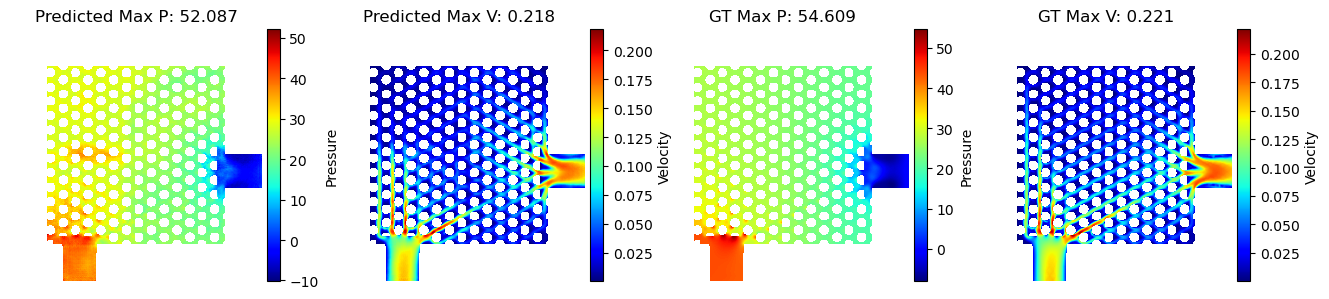

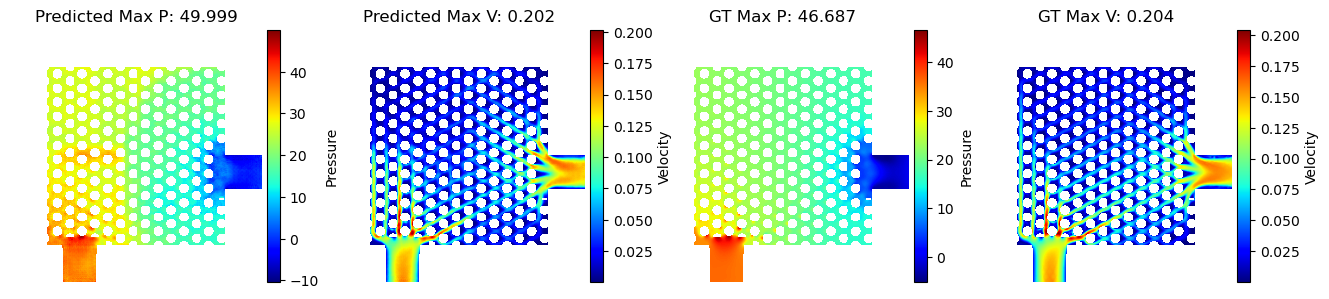

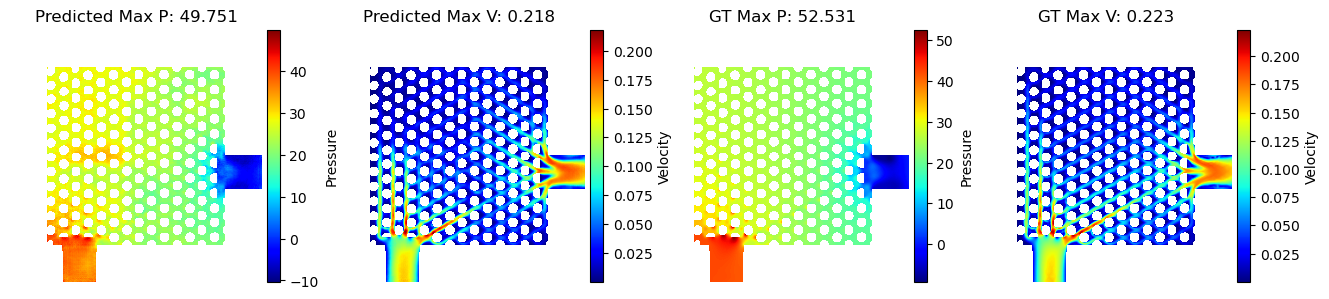

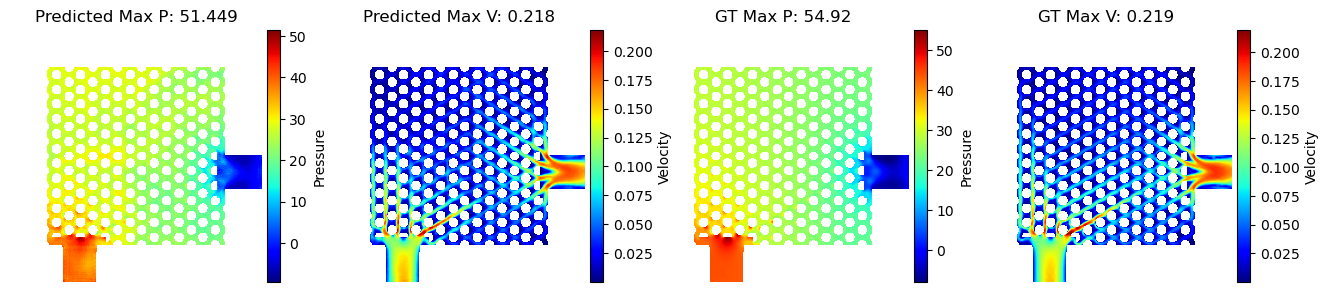

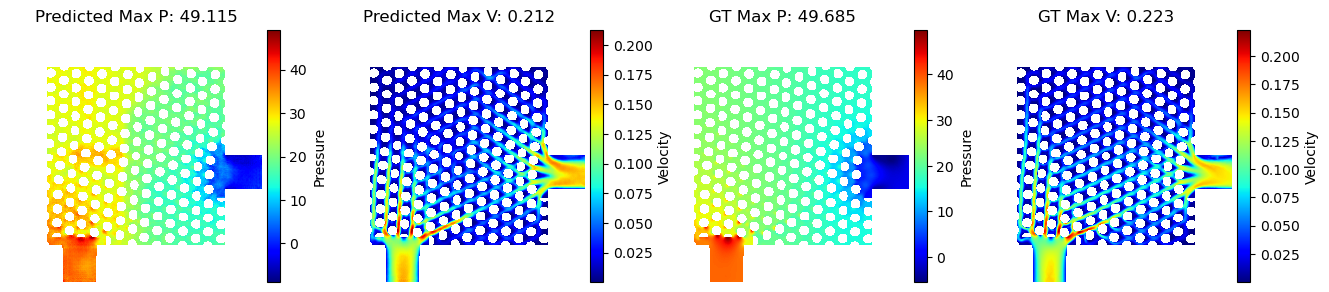

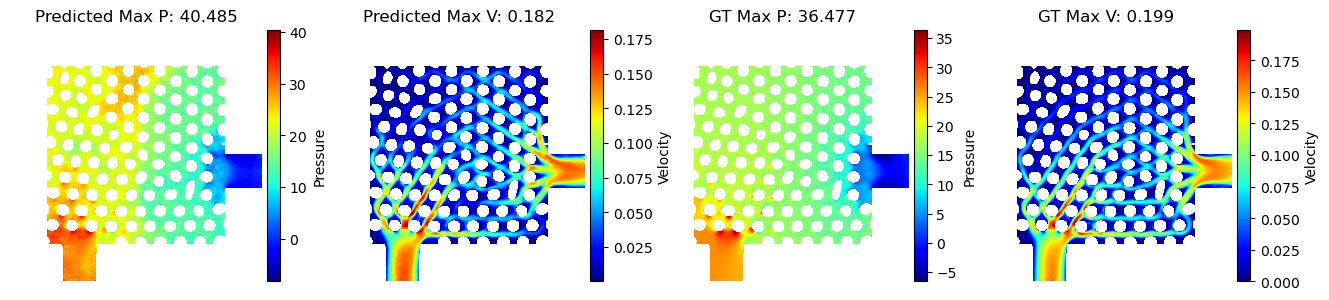

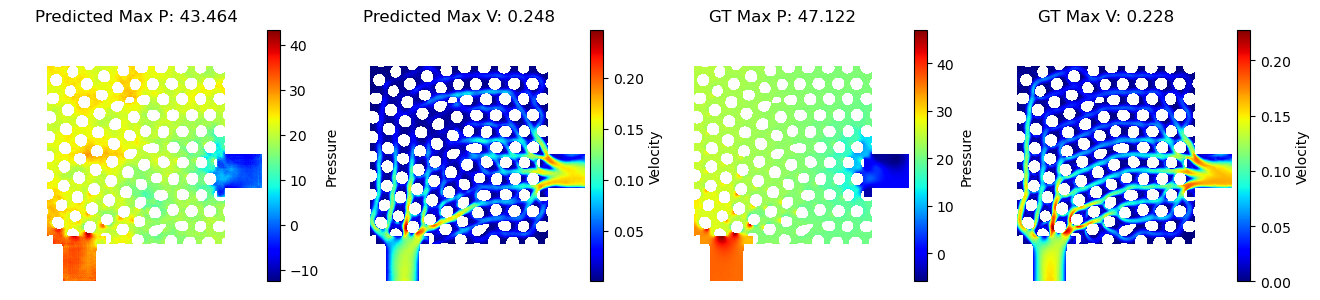

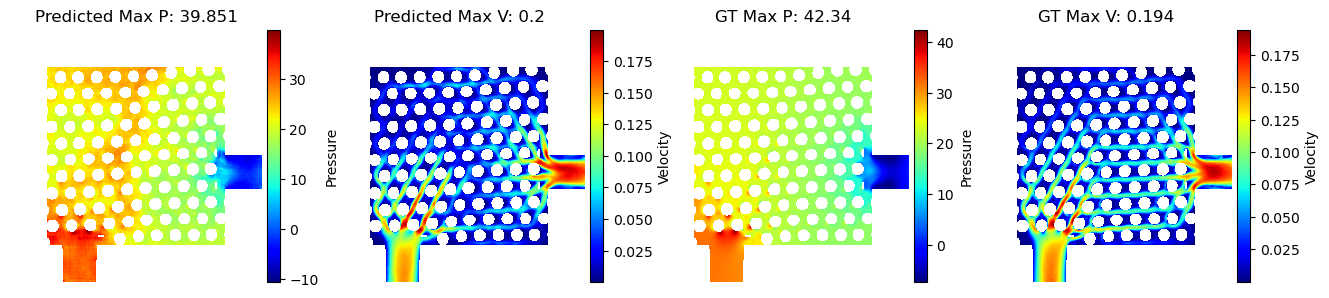

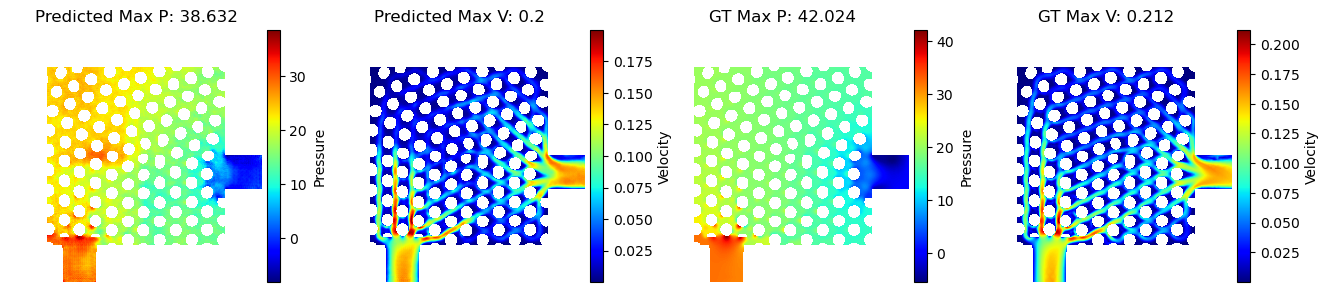

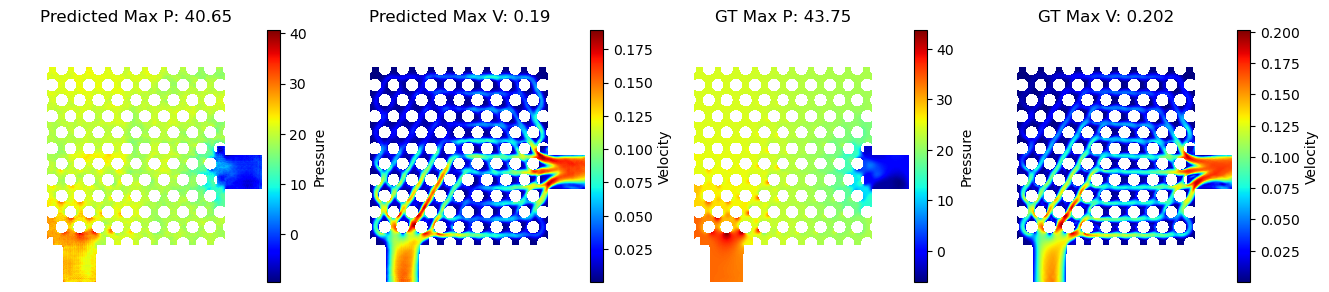

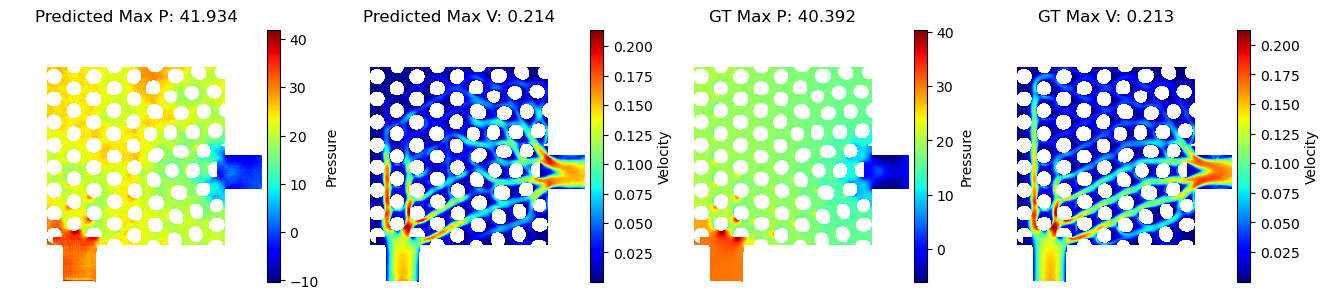

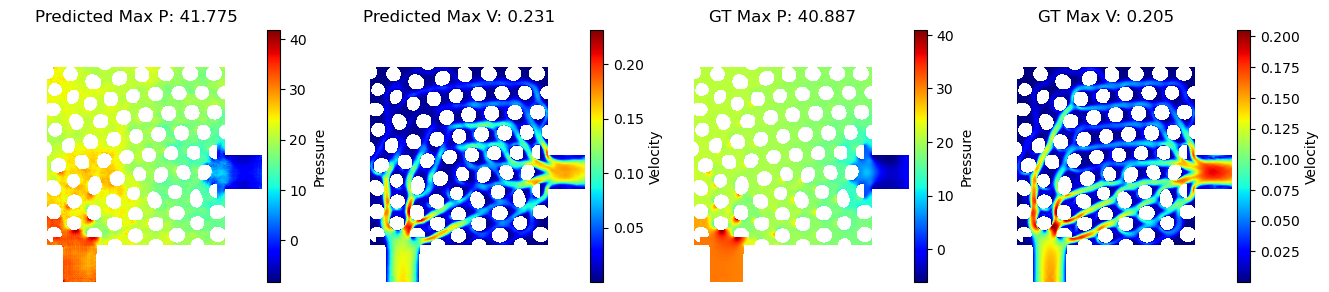

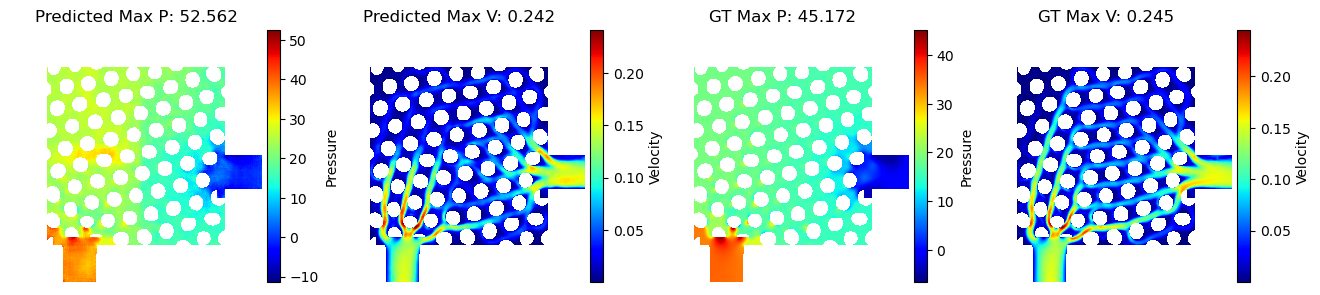

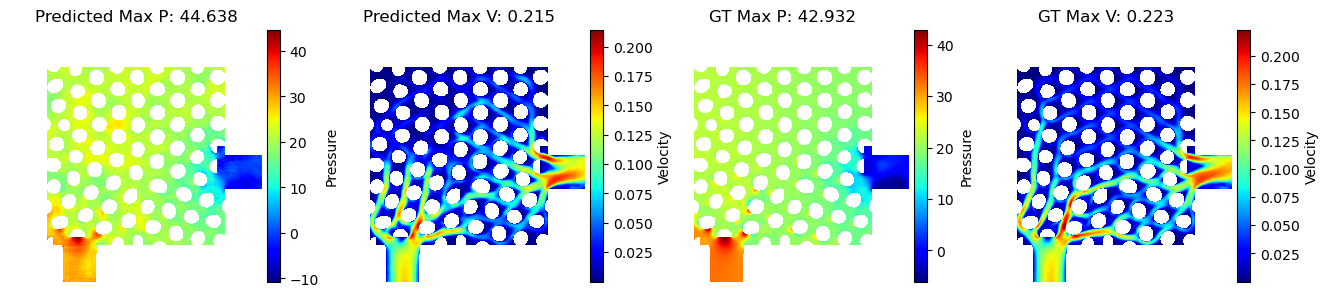

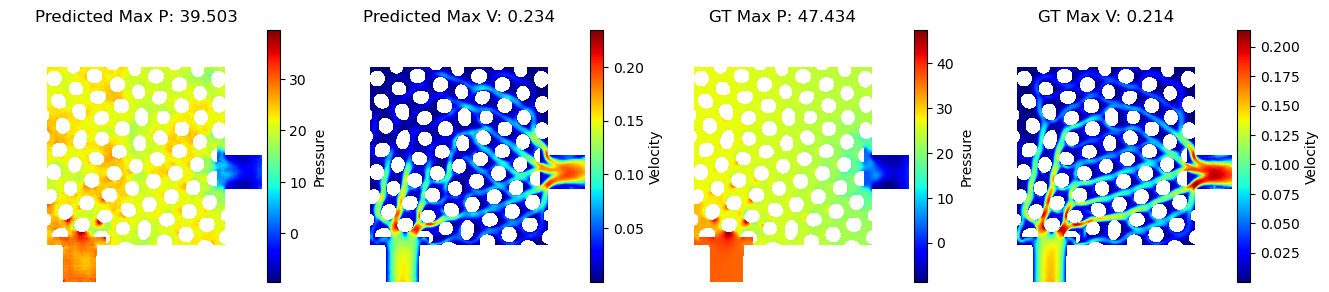

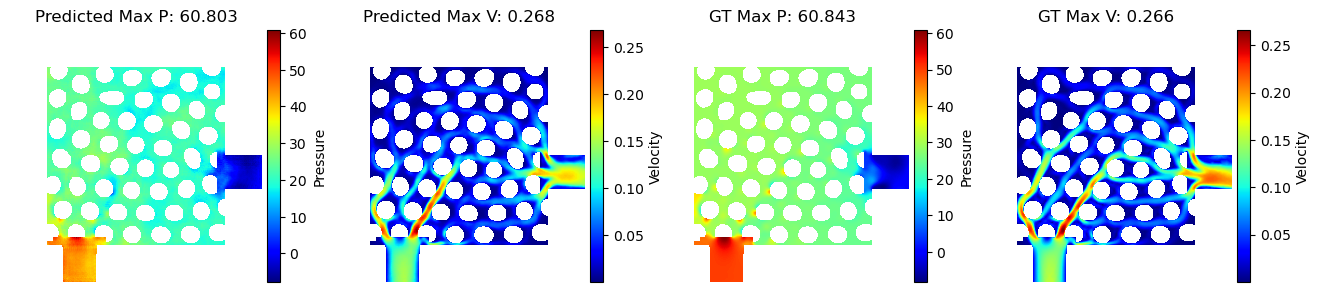

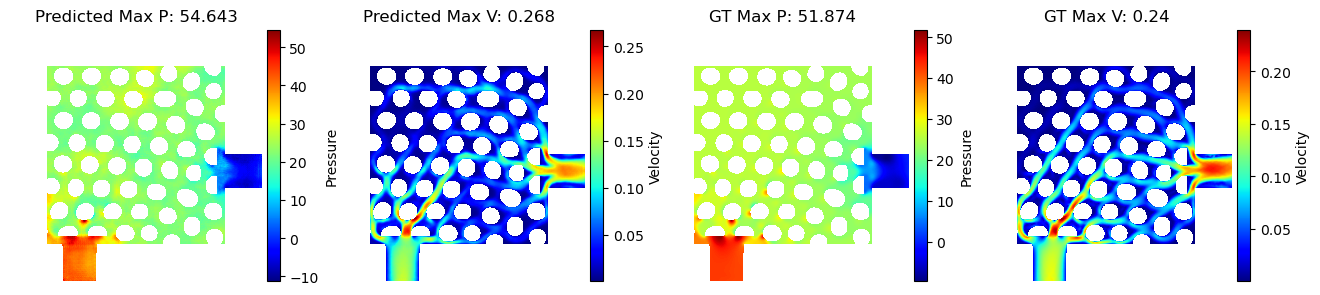

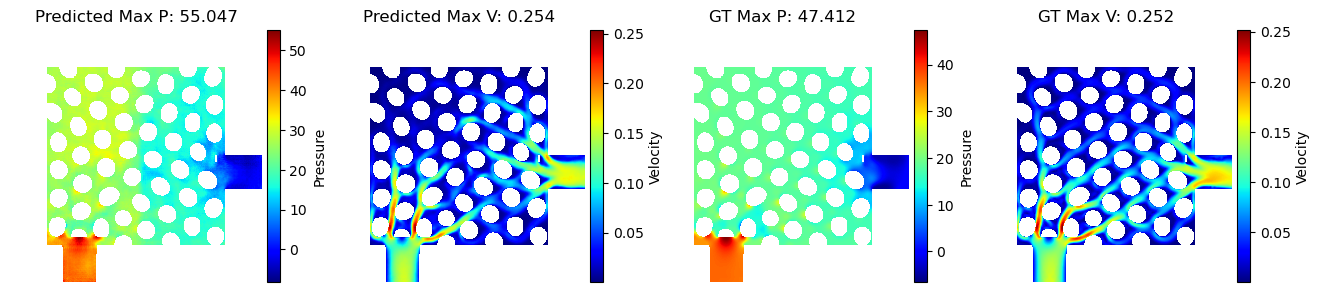

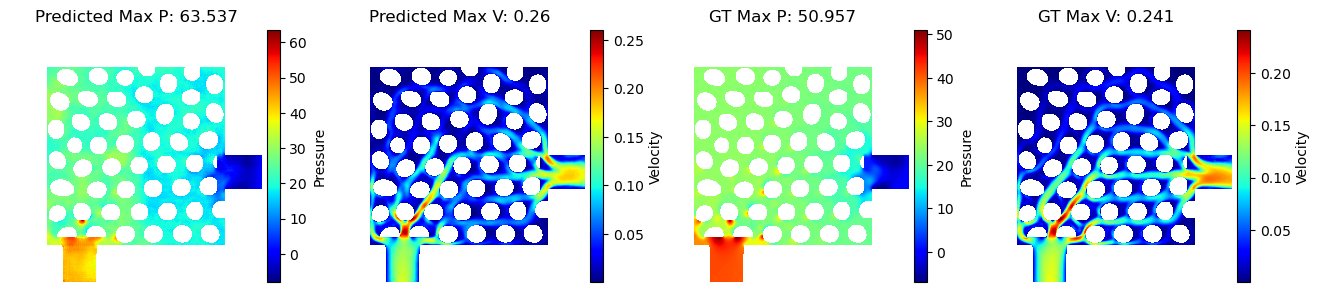

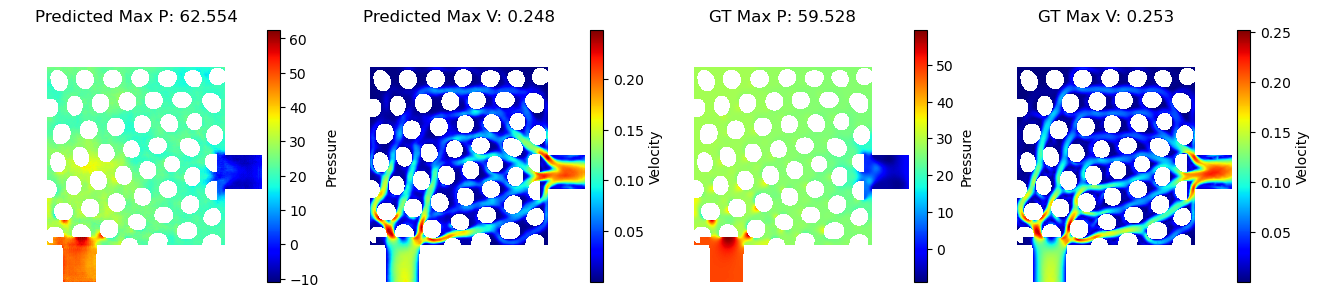

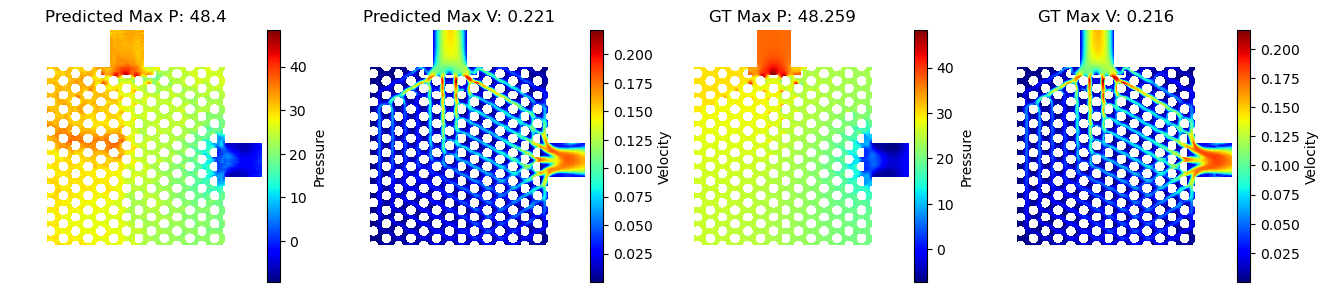

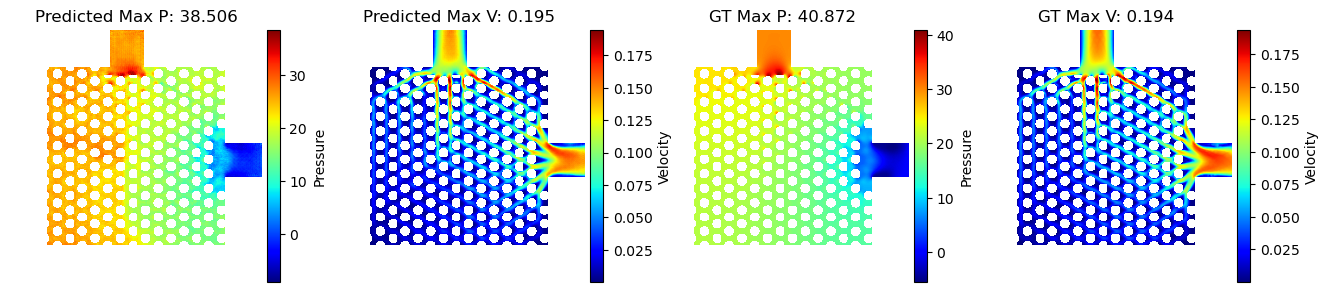

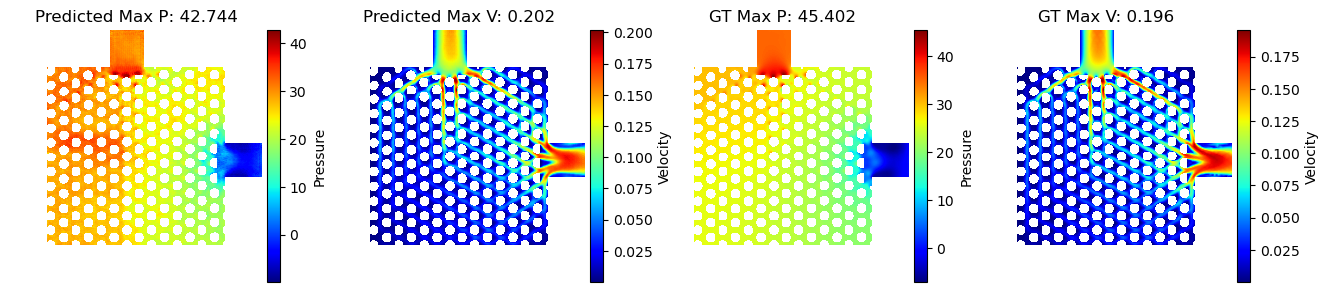

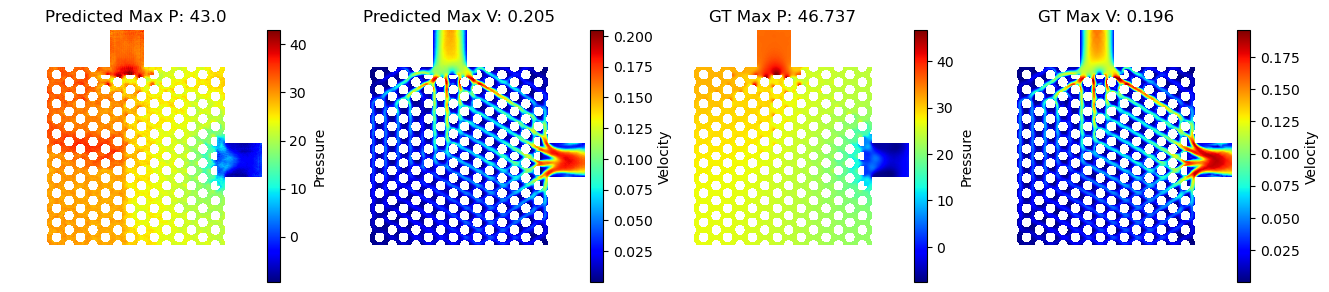

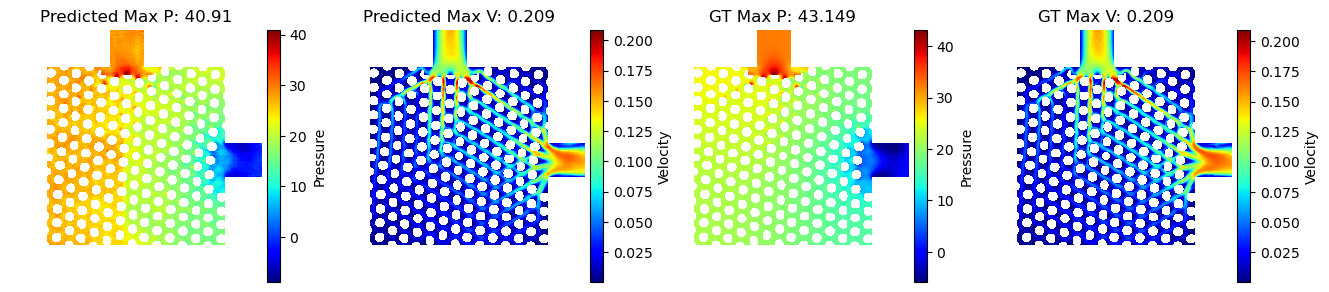

In [2]:
import matplotlib.pyplot as plt



hv2_folder = 'Validation/High/HVV'
hp2_folder = 'Validation/High/HPP'
lg2_folder = 'Validation/LG-3C2'

# Get the list of file names in each folder

hv2_files = [f2 for f2 in os.listdir(hv2_folder) if f2 != ".ipynb_checkpoints"]
hp2_files = [f2 for f2 in os.listdir(hp2_folder) if f2 != ".ipynb_checkpoints"]
lg2_files = [f2 for f2 in os.listdir(lg2_folder) if f2 != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent
hv2_files.sort()
hp2_files.sort()
lg2_files.sort()


# Set the input shape
input_shape = (256, 256, 3)  # Update to 3 channels for color images

# Create empty lists to store the data
X_lg2 = []
Y_hv2 = []
Y_hp2 = []

# Read the data from the folders
for hv2_file,hp2_file,lg2_file in zip( hv2_files,hp2_files,lg2_files):
    try:
        
        

        # Read the HFV
        hv2_image = np.load(os.path.join(hv2_folder, hv2_file))  # Convert to RGB
        Y_hv2.append(np.array(hv2_image))

    
    
        # Read the channel geometry image
        lg2_image = Image.open(os.path.join(lg2_folder, lg2_file)).convert('RGB')  # Convert to RGB
        lg2_image = lg2_image.resize(input_shape[:2])  # Resize the image
        X_lg2.append(np.array(lg2_image))
    
        # Read the HFP
        hp2_image = np.load(os.path.join(hp2_folder, hp2_file))  # Convert to RGB
        Y_hp2.append(np.array(hp2_image))
    except:
        print('')

# Convert the lists to arrays


X_lg2 = np.array(X_lg2) / 255.0  # Normalize the channel geometry images
Y_hv2 = np.array(Y_hv2)
Y_hp2 = np.array(Y_hp2)



model.load_weights('Saved_Models_Temp/Final-Data-Unet-Zero.h5')

pressure_output2,velocity_output2 = model.predict([X_lg2])

velocity_output2=(velocity_output2)
a=(np.max(Y_hp)-np.min(Y_hp))
b=(np.min(Y_hp))

pressure_output2=(pressure_output2*a)+b



mask = np.all(X_lg2 > 0.8, axis=-1)

# Expand mask to match the shape of array2
mask_expanded = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
Y_hp2[mask]=np.nan
Y_hv2[mask]=np.nan
velocity_output2[mask]=np.nan
pressure_output2[mask]=np.nan

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming pressure_output, velocity_output, Y_hp, and Y_hv are defined and loaded elsewhere




def plot_images(index):
    plt.figure(figsize=(16, 48))

    # Display the pressure output
    ax1 = plt.subplot(1, 4, 1)
    im1 = ax1.imshow(pressure_output2[index],cmap='jet')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1, label='Pressure')
    ax1.set_title('Predicted Max P: '+ str(np.round(np.nanmax(pressure_output2[index]),decimals=3)))
    ax1.axis("off")

    # Display the velocity output
    ax2 = plt.subplot(1, 4, 2)
    im2 = ax2.imshow(velocity_output2[index],cmap='jet')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2, label='Velocity')
    ax2.set_title('Predicted Max V: '+ str(np.round(np.nanmax(velocity_output2[index]),decimals=3)))
    ax2.axis("off")

    # Display the input image (Pressure GT)
    ax3 = plt.subplot(1, 4, 3)
    im3 = ax3.imshow(Y_hp2[index],cmap='jet')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3, label='Pressure')
    ax3.set_title('GT Max P: '+ str(np.round(np.nanmax(Y_hp2[index]),decimals=3)))
    ax3.axis("off")

    # Display the velocity GT
    ax4 = plt.subplot(1, 4, 4)
    im4 = ax4.imshow(Y_hv2[index],cmap='jet')
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax4, label='Velocity')
    ax4.set_title('GT Max V: '+ str(np.round(np.nanmax(Y_hv2[index]),decimals=3)))
    ax4.axis("off")

    plt.show()

# Loop to plot images 
for i in range(0, 25):
    plot_images(i)

In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr


Yp = np.expand_dims(Y_hp2, axis=-1)
Yv = np.expand_dims(Y_hv2, axis=-1)


expected = Yp
predicted = pressure_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 137.2746
MAE: 5.1989
RMSE: 11.7164
R^2: 0.7556
NRMSE: 0.0204
Relative Error: 1.2368
SMAPE: 24.9733%
Pearson Correlation: 0.8697
PSNR: 32.9331 dB


In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Dummy data (replace with actual predicted and expected arrays)
expected = Yv
predicted = velocity_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 0.00052178
MAE: 0.0133
RMSE: 0.0228
R^2: 0.8271
NRMSE: 0.0250
Relative Error: 380041613.1360
SMAPE: 55.0988%
Pearson Correlation: 0.9101
PSNR: 32.0260 dB


In [7]:
path1="Results_Temp/Data/Zero-Fidelity"
os.makedirs(path1, exist_ok=True)
np.save(path1+"/velocity_predicted.npy",velocity_output2)
np.save(path1+"/pressure_predicted.npy",pressure_output2)
